In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import re
from src.utils import get_auc, get_empirical_cdf, get_all, _process_evalharness_results, get_superglue_results
import pandas as pd

from src.figure_plotting_utils import *

/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams.update({
    # Fonts (increased further for visibility)
    'font.size': 28,                      # Default font size
    'font.family': 'serif',               # Set font family to 'serif'
    'font.serif': ['Times New Roman', 'DejaVu Math TeX Gyre', 'DejaVu Serif'],  # Serif fonts
    'axes.titlesize': 30,                 # Title font size (even larger)
    'axes.labelsize': 30,                 # Axis label font size
    'legend.fontsize': 26,                # Legend font size
    'xtick.labelsize': 24,                # X-tick label font size
    'ytick.labelsize': 24,                # Y-tick label font size
    
    # Figure size and DPI
    'figure.figsize': [10, 8],            # Same figure size, but adjust as needed
    'figure.dpi': 100,                    # Higher resolution for clarity
    
    # Line properties
    'lines.linewidth': 4,                 # Default line thickness
    'lines.markersize': 15,               # Marker size
    
    # Axes
    'axes.grid': True,                    # Grid on
    'grid.color': 'gray',                 # Grid color
    'grid.linestyle': '-',                # Solid grid line style
    'grid.linewidth': 0.75,               # Grid line width
    'axes.edgecolor': 'black',            # Axes border color
    'axes.linewidth': 1.5,                # Thicker axes border
    'axes.titleweight': 'bold',           # Bold titles
    
    # Set default x-axis to start at 0
    'axes.autolimit_mode': 'round_numbers',  # Round axis limits
    'axes.xmargin': 0.0,                    # Remove extra margin on x-axis
    'axes.ymargin': 0.05,                 # Slight y-axis margin
    
    # Ticks
    'xtick.major.size': 7,                # Major tick size
    'xtick.major.width': 1.5,             # Major tick width
    'ytick.major.size': 7,                # Major tick size
    'ytick.major.width': 1.5,             # Major tick width
    
    # Legend
    'legend.frameon': True,               # Frame around legend
    'legend.framealpha': 0.9,             # Slightly transparent frame
    'legend.fancybox': True,              # Rounded corners
    
    # Save figure
    'savefig.dpi': 300,                   # High resolution for saving
    'savefig.format': 'png',              # Save format
    'savefig.bbox': 'tight',              # Tight layout for saving
})
default_cycler = plt.rcParams['axes.prop_cycle']
default_cycler = [c['color'] for c in default_cycler]

In [3]:
TASKS = {
        'boolq':'acc',
        'cb':'acc',
        'copa':'acc',
        'multirc':'acc',
        'record': 'f1',
        'rte':'acc',
        'wic':'acc',
        'wsc':'acc',
        'gsm8k_cot_self_consistency': 'exact_match,flexible-extract'
    }

In [4]:
amlt_parent = '/home/blockadam/gaussian-watermarking/amlt'
figs_parent = '/home/blockadam/gaussian-watermarking/figs/low_rank_figs'
save_figs = True

# Getting Data

In [5]:
good_models_df = pd.read_csv('good_models.csv')
good_models_df = add_win_rates(good_models_df)

In [6]:
num_tokens_exps = [
    # '11-04-watermark-numtokens'
    '11-06-watermark-numtokens-lowrank'
]
num_tokens_parents = [os.path.join(amlt_parent, exp) for exp in num_tokens_exps]

num_tokens_generations, num_tokens_data = get_num_tokens_generations(num_tokens_parents)



In [7]:
# good_models = {
#     'Mistral':  ('model.layers.20.mlp.up_proj.weight', 1e-05, 0), # ('model.layers.30.mlp.gate_proj.weight', 1e-05, 0), # ('model.layers.28.mlp.up_proj.weight', 1e-05, 0), #
#     'Llama': ('model.layers.28.mlp.up_proj.weight', 0.0003, 0),
#     'Phi':    ('model.layers.20.mlp.down_proj.weight', 0.001, 0),
#     'LlamaWeak':     ('model.layers.29.mlp.down_proj.weight', 0.0001, 0), # ('model.layers.28.mlp.up_proj.weight', 0.0003, 0), # 
# }
good_models_lowrank = {
    'MistralLowRank': ('model.layers.30.mlp.up_proj.weight', 1e-05, 1024), # ('model.layers.30.mlp.gate_proj.weight', 1e-05, 512),
    'LlamaLowRank': ('model.layers.29.mlp.down_proj.weight', 0.0001, 512), # ('model.layers.31.mlp.up_proj.weight', 3e-05, 1024), # 
    'PhiLowRank': ('model.layers.31.mlp.gate_up_proj.weight', 0.0003, 1024)  #
}
good_models = {}
for key, val in good_models_lowrank.items():
    good_models[key.replace('LowRank', '')] = val

# good_models.update(good_models_lowrank)


model_mappings = {
    'Mistral': 'mistralai/Mistral-7B-v0.3',
    'Llama': 'meta-llama/Meta-Llama-3.1-8B',
    'Phi': 'microsoft/Phi-3-mini-4k-instruct'
}

model_mappings['LlamaWeak'] = 'meta-llama/Meta-Llama-3.1-8B'
model_mappings['MistralLowRank'] = 'mistralai/Mistral-7B-v0.3'
model_mappings['LlamaLowRank'] = 'meta-llama/Meta-Llama-3.1-8B'
model_mappings['PhiLowRank'] = 'microsoft/Phi-3-mini-4k-instruct'


In [8]:
for alias in good_models.keys():
    row_idx = row_lookup[(good_models[alias], model_mappings[alias])]
    print(f"{alias}: Row {row_idx}, Watermark Overrides {good_models_df.loc[row_idx, 'watermark_overrides']}")

# print('\n\n')
# for alias in good_models_lowrank.keys():
#     row_idx = row_lookup[(good_models_lowrank[alias], model_mappings[alias])]
#     print(f"{alias}: Row {row_idx}, Watermark Overrides {good_models_df.loc[row_idx, 'watermark_overrides']}")

Mistral: Row 110, Watermark Overrides mistralai/Mistral-7B-v0.3@___@1024@___@30@@@up_proj@@@weight@___@1e-05
Llama: Row 79, Watermark Overrides meta-llama/Meta-Llama-3.1-8B@___@512@___@29@@@down_proj@@@weight@___@0.0001
Phi: Row 105, Watermark Overrides microsoft/Phi-3-mini-4k-instruct@___@1024@___@31@@@gate_up_proj@@@weight@___@0.0003


In [9]:

parents = [
    # '11-04-corruption-robust-seeds'
    '11-06-corruption-robust-seeds-lowrank'
]

parents = [os.path.join('./amlt', parent) for parent in parents]

# corrupt_generations = get_corruptions(parents, good_models)

corrupt_generations = get_corruptions_seeds(parents, good_models, num_tokens_generations)


Error processing ./amlt/11-06-corruption-robust-seeds-lowrank/grid_11-06-corruption-robust-seeds-lowrank_cor_remove_start_tokens_see_1997_tok_0.5_wat_meta-llama_Meta-Llama-3.1-8B_____512_____29___down_proj___weight_____0.0001: [Errno 2] No such file or directory: './amlt/11-06-corruption-robust-seeds-lowrank/grid_11-06-corruption-robust-seeds-lowrank_cor_remove_start_tokens_see_1997_tok_0.5_wat_meta-llama_Meta-Llama-3.1-8B_____512_____29___down_proj___weight_____0.0001/generations.json'
Error processing ./amlt/11-06-corruption-robust-seeds-lowrank/grid_11-06-corruption-robust-seeds-lowrank_cor_remove_start_tokens_see_1997_tok_0.4_wat_meta-llama_Meta-Llama-3.1-8B_____512_____29___down_proj___weight_____0.0001: [Errno 2] No such file or directory: './amlt/11-06-corruption-robust-seeds-lowrank/grid_11-06-corruption-robust-seeds-lowrank_cor_remove_start_tokens_see_1997_tok_0.4_wat_meta-llama_Meta-Llama-3.1-8B_____512_____29___down_proj___weight_____0.0001/generations.json'
Error processing

In [10]:
def get_win_rate(model, good_models=good_models, good_models_df=good_models_df, row_lookup=row_lookup, model_mappings=model_mappings):
    param = good_models[model]
    model_name = model_mappings[model]
    idx = row_lookup[(param, model_name)]
    row = good_models_df.iloc[idx]
    return row['win_rate']

mistral_win_rate = get_win_rate('Mistral')
llama_win_rate = get_win_rate('Llama')
phi_win_rate = get_win_rate('Phi')

# llama_weak_win_rate = get_win_rate('LlamaWeak')


print(f"Mistral win rate: {mistral_win_rate:.4f}")
print(f"Llama win rate: {llama_win_rate:.4f}")
# print(f"LlamaWeak win rate: {llama_weak_win_rate:.4f}")
print(f"Phi win rate: {phi_win_rate:.4f}")



# llama_lowrank_win_rate = get_win_rate('LlamaLowRank')
# mistral_lowrank_win_rate = get_win_rate('MistralLowRank')
# phi_lowrank_win_rate = get_win_rate('PhiLowRank')
# print(f"MistralLowRank win rate: {mistral_lowrank_win_rate:.4f}")
# print(f"LlamaLowRank win rate: {llama_lowrank_win_rate:.4f}")
# print(f"PhiLowRank win rate: {phi_lowrank_win_rate:.4f}")


Mistral win rate: 0.4567
Llama win rate: 0.4910
Phi win rate: 0.4894


# Numtokens plots

8
8
8


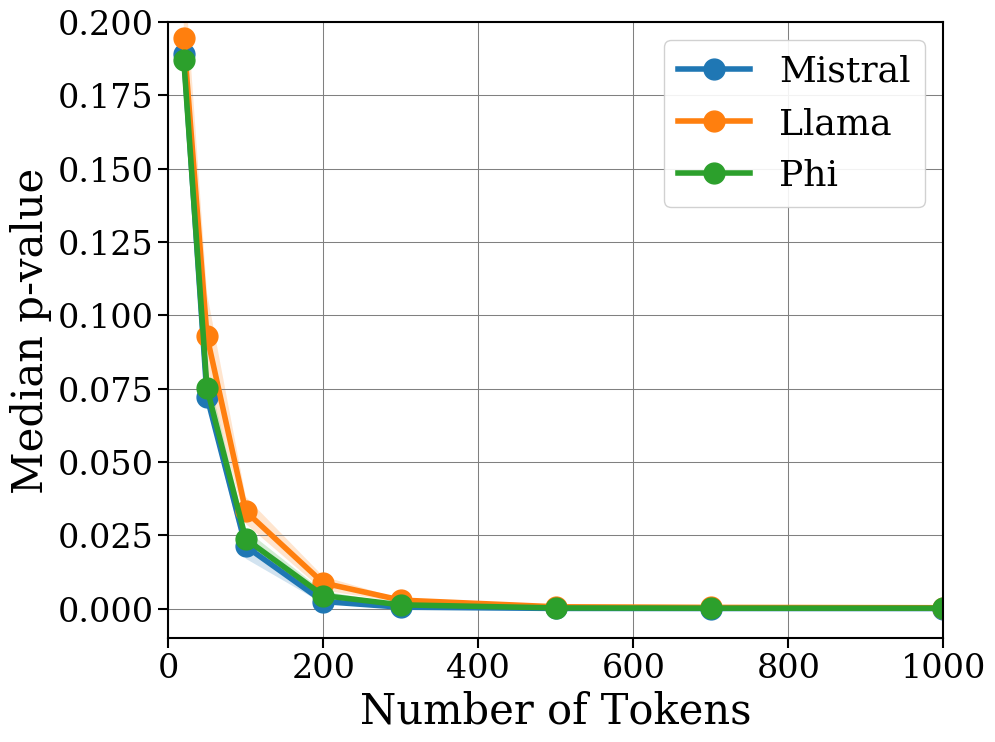

In [11]:
# model = 'microsoft/Phi-3-mini-4k-instruct'
# model = 'mistralai/Mistral-7B-v0.3'
# model = 'meta-llama/Meta-Llama-3.1-8B'
sig_pval = 0.05



# model = 'microsoft/Phi-3-mini-4k-instruct'
# model = 'mistralai/Mistral-7B-v0.3'
# model = 'meta-llama/Meta-Llama-3.1-8B'
min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in good_models.items():
    if 'Weak'  in model:
        continue
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile], has_seeds=True)

    print(len(medians))


    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]

    

    # num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile], has_seeds=False)
    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(-0.01, 0.2)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Median p-value')
# fig.suptitle(f"LowRank Detecting Watermark")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'numtokens-medians.png'))

plt.show()

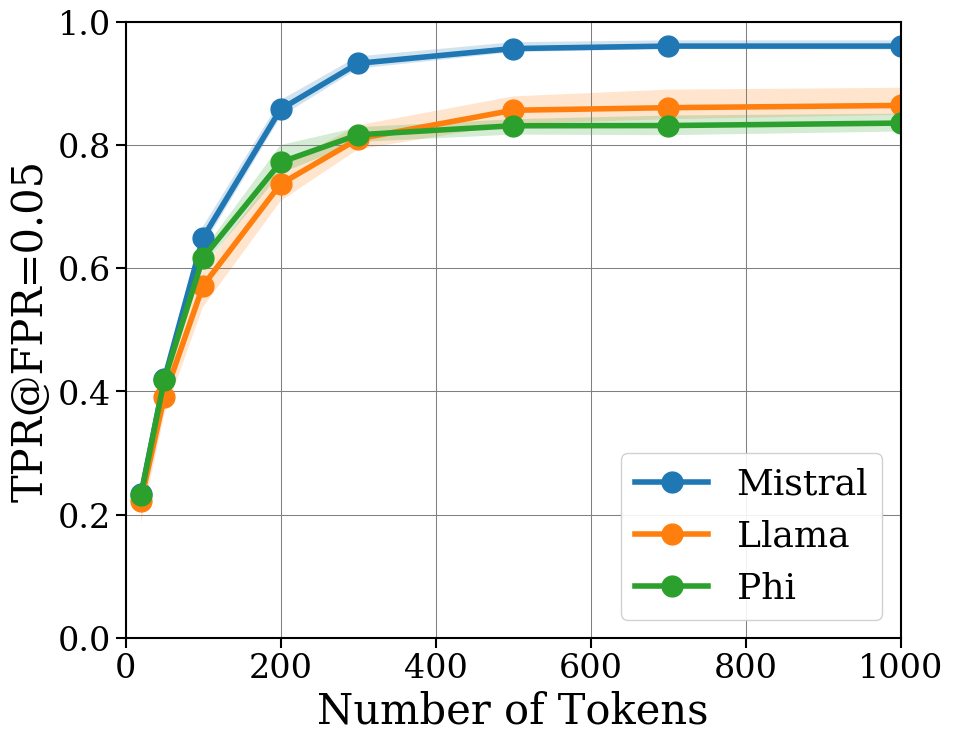

In [12]:


fig, ax = plt.subplots()
for model, param in good_models.items():
    if 'Weak'  in model:
        continue
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)
    
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]
    
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"LowRank Detected Watermarks")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-numpassed-{sig_pval}.png'))

plt.show()

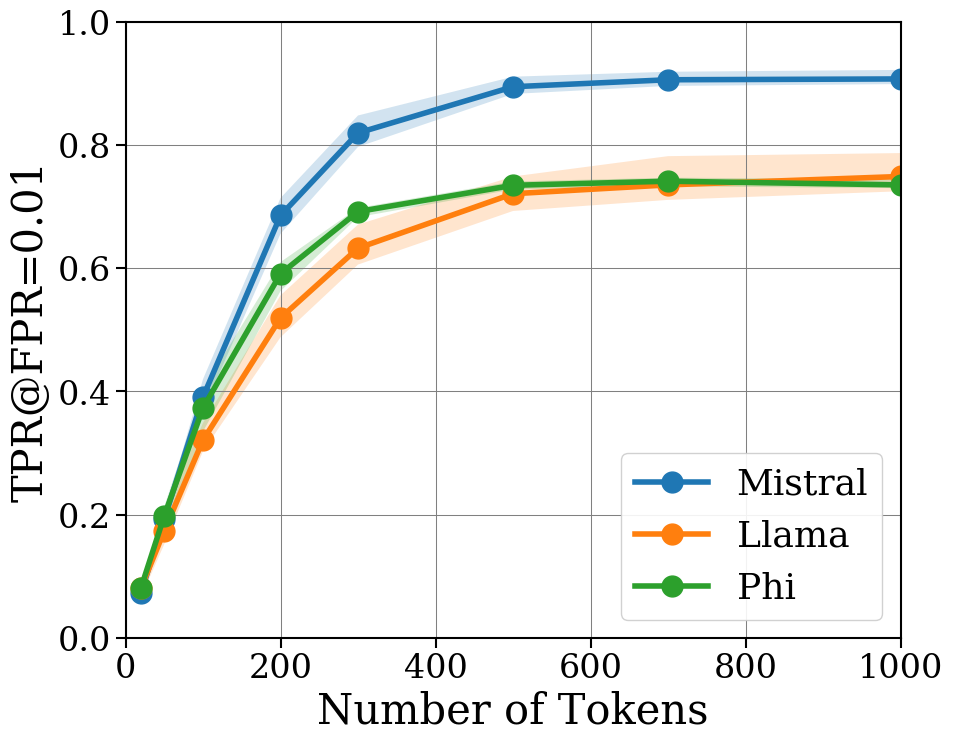

In [13]:
sig_pval = 0.01

fig, ax = plt.subplots()
for model, param in good_models.items():
    if 'Weak'  in model:
        continue
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)
    
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]
    num_passed = [passed[1] for passed in num_passed]
    
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"LowRank Detected Watermarks")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-numpassed-{sig_pval}.png'))

plt.show()

In [14]:
sig_pval = 0.05

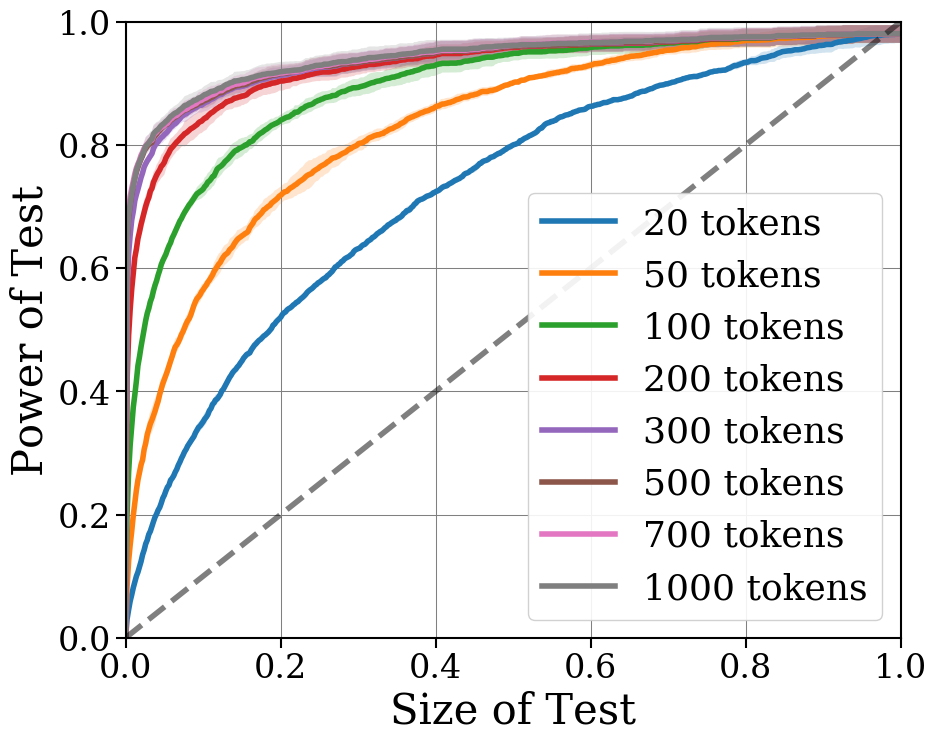

In [15]:
model = 'Phi'

fig, ax = plt.subplots()
param = good_models[model]
model_name = model_mappings[model]
data_dict = num_tokens_data[model_name][param]
data_dict = {key:data_dict[key] for key in sorted(data_dict.keys())}

for num_tokens, pvals in data_dict.items():
    cdfs = []
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        cdfs.append(cdf)
    
    cdfs = np.array(cdfs)
    means, stds = np.mean(cdfs, axis=0), np.std(cdfs, axis=0)
    ax.plot(grid, means, label=f"{num_tokens} tokens")
    ax.fill_between(grid, means-stds, means+stds, alpha=0.2)

ax.legend()
ax.plot([0, 1], [0, 1], color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')

# fig.suptitle(f"LowRank ROC for {model}")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-roc-{model}.png'))

plt.show()

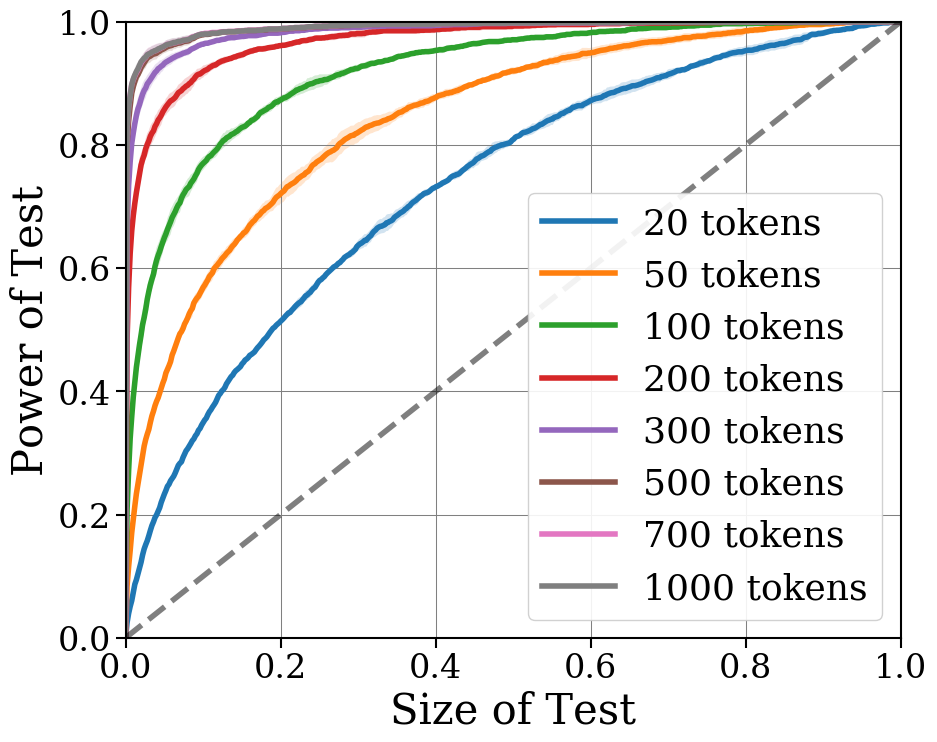

In [16]:
model = 'Mistral'

fig, ax = plt.subplots()
param = good_models[model]
model_name = model_mappings[model]
data_dict = num_tokens_data[model_name][param]
data_dict = {key:data_dict[key] for key in sorted(data_dict.keys())}

for num_tokens, pvals in data_dict.items():
    cdfs = []
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        cdfs.append(cdf)
    
    cdfs = np.array(cdfs)
    means, stds = np.mean(cdfs, axis=0), np.std(cdfs, axis=0)
    ax.plot(grid, means, label=f"{num_tokens} tokens")
    ax.fill_between(grid, means-stds, means+stds, alpha=0.2)

ax.legend()
ax.plot([0, 1], [0, 1], color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')

# fig.suptitle(f"LowRank ROC for {model}")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-roc-{model}.png'))

plt.show()

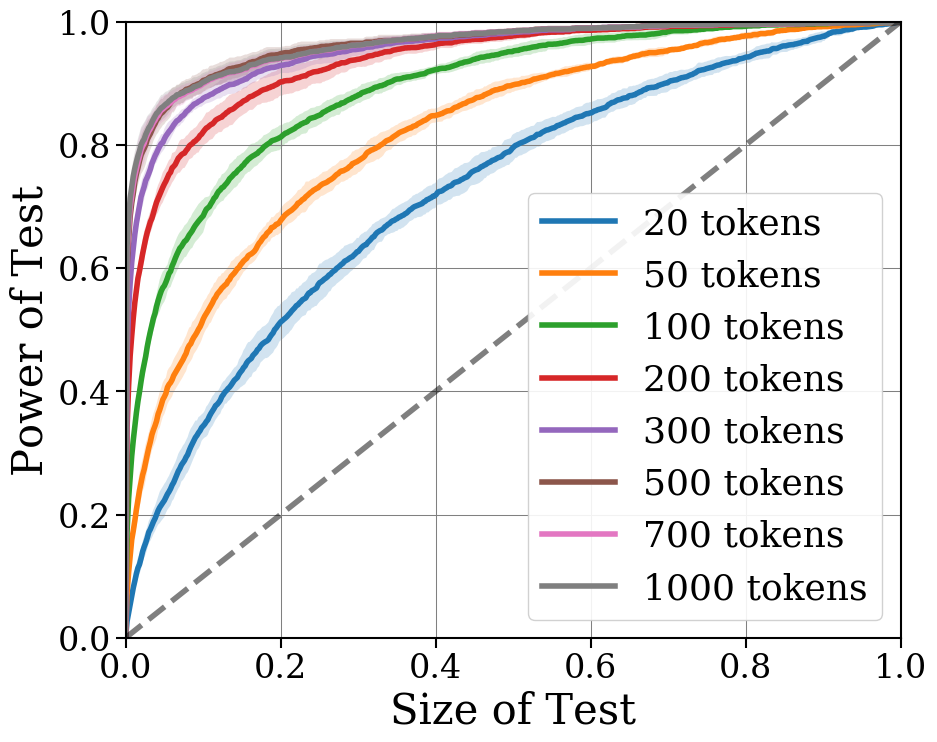

In [17]:
model = 'Llama'

fig, ax = plt.subplots()
param = good_models[model]
model_name = model_mappings[model]
data_dict = num_tokens_data[model_name][param]
data_dict = {key:data_dict[key] for key in sorted(data_dict.keys())}

for num_tokens, pvals in data_dict.items():
    cdfs = []
    for seed in pvals.keys():
        grid, cdf = get_empirical_cdf(pvals[seed]['pvalue'], grid_size=500)
        cdfs.append(cdf)
    
    cdfs = np.array(cdfs)
    means, stds = np.mean(cdfs, axis=0), np.std(cdfs, axis=0)
    ax.plot(grid, means, label=f"{num_tokens} tokens")
    ax.fill_between(grid, means-stds, means+stds, alpha=0.2)

ax.legend()
ax.plot([0, 1], [0, 1], color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')

# fig.suptitle(f"LowRank ROC for {model}")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'numtokens-roc-{model}.png'))

plt.show()

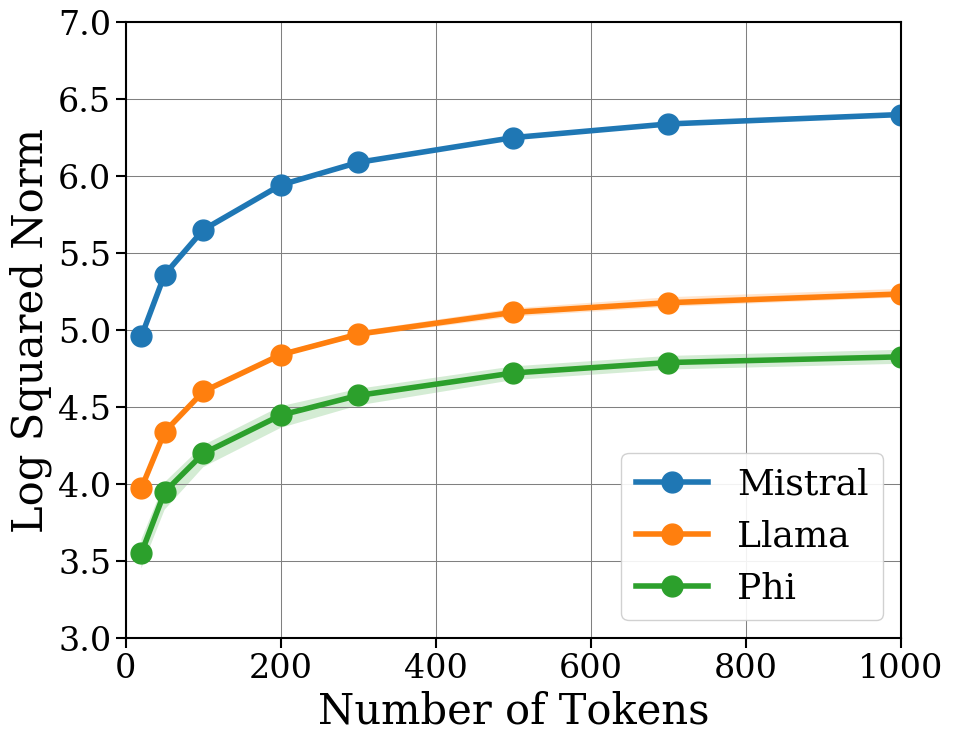

In [18]:
fig, ax = plt.subplots()
for model, param in good_models.items():
    if 'Weak'  in model:
        continue
    model_name = model_mappings[model]
    data_dict = num_tokens_data[model_name][param]
    added_var = param[1]
    num_tokens, avg_squared_norms, stderrs = get_avg_squared_norms(data_dict, added_var)

    lbs = [norm[0] for norm in avg_squared_norms]
    ubs = [norm[-1] for norm in avg_squared_norms]
    avg_squared_norms = [norm[1] for norm in avg_squared_norms]

    ax.plot(num_tokens, np.log10(avg_squared_norms), label=model, marker='o')
    ax.fill_between(num_tokens, np.log10(lbs), np.log10(ubs), alpha=0.2)

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
# ax.set_ylim(0, 1)
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Log Squared Norm')
# fig.suptitle(f"LowRank Gradient of Log Probabilities")


if save_figs:
    fig.savefig(os.path.join(figs_parent, 'numtokens-gradnorm.png'))

plt.show()

/home/blockadam/gaussian-watermarking/gaussian_watermarking/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


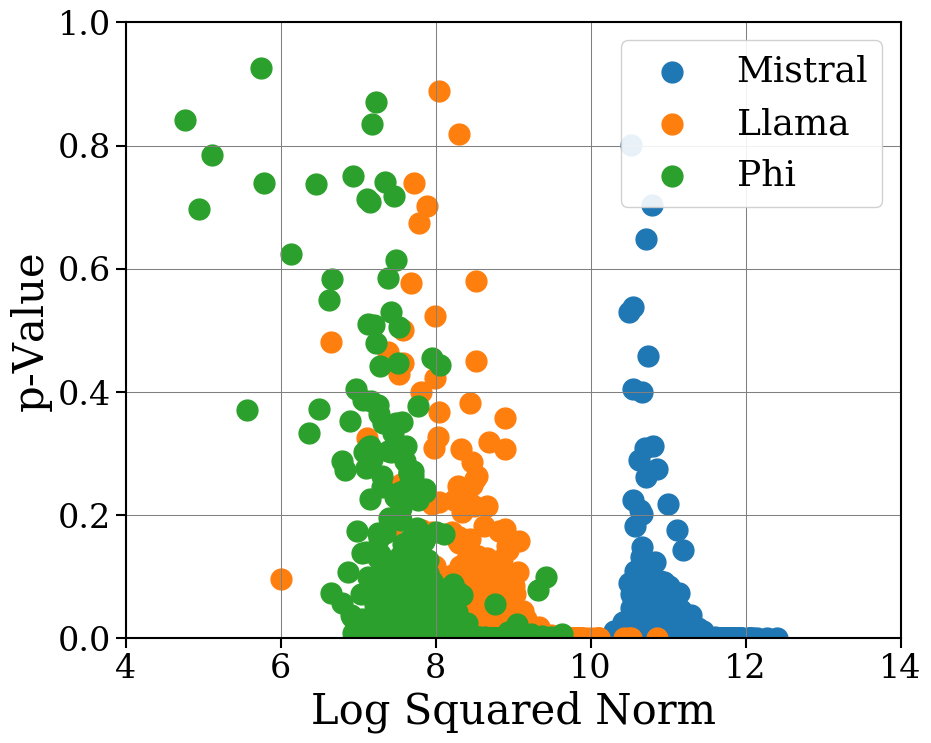

In [19]:
fig, ax = plt.subplots()
num_tokens = 1000
seed = 1337
for model, param in good_models.items():
    if 'Weak'  in model:
        continue
    model_name = model_mappings[model]
    temp = num_tokens_data[model_name][param][num_tokens]
    sigma = param[1]
    grad_norms, pvals = np.log10(temp[seed]['variance']) - 2 * np.log10(sigma), temp[seed]['pvalue']
    ax.scatter(grad_norms, pvals, label=model, marker='o')

ax.legend()
# ax.axhline(1.0, color='black', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel('Log Squared Norm')
ax.set_ylabel('p-Value')
# fig.suptitle(f"p-Values vs. Gradient Norms at {num_tokens} Tokens (LowRank)")


if save_figs:
    fig.savefig(os.path.join(figs_parent, 'gradnorms-pvalues-scatter-1k.png'))

plt.show()

# Corruptions Ablations

## Fraction significant

### TODO: Adapt this to give the average over multiple seeds.

In [20]:
sig_pval = 0.05

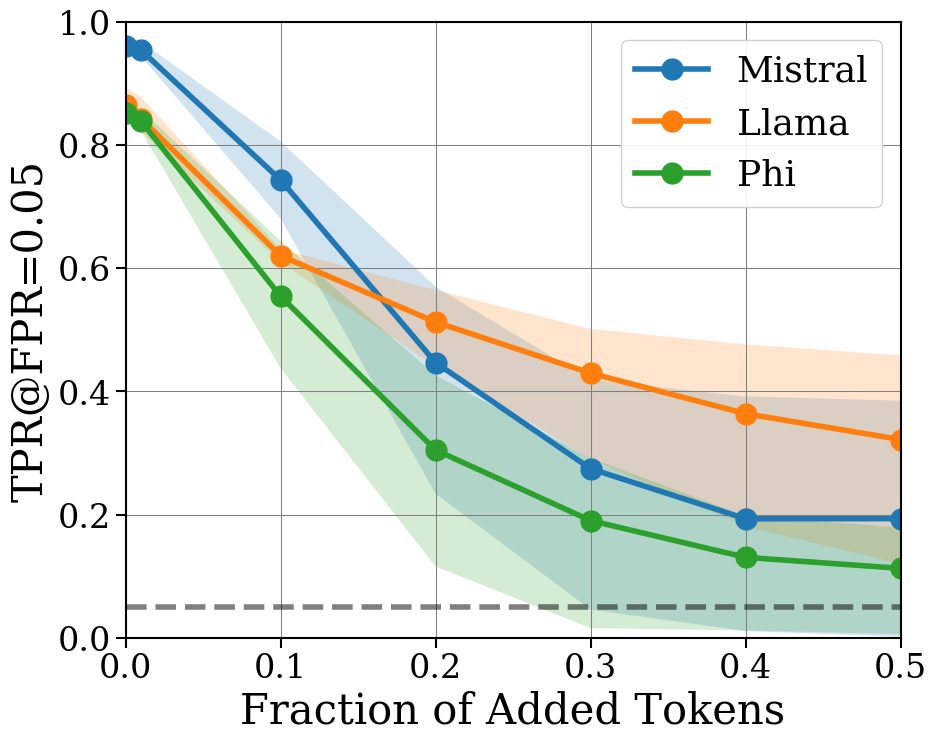

In [21]:
corrupt_models = good_models

corruption_type = 'add_random_tokens'

fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {}


    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval, has_seeds=True)

    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


    # num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval, has_seeds=False)
    # ax.plot(num_tokens, num_passed, label=model, marker='o')


ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"LowRank Adding Random Tokens")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-add-random-sig{sig_pval}.png'))

plt.show()

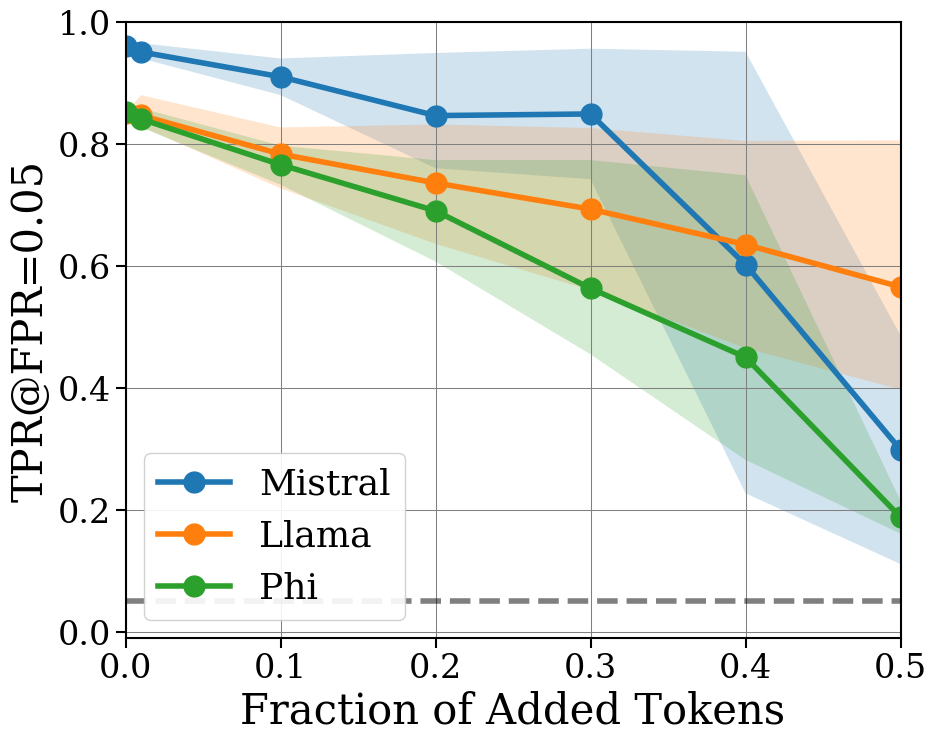

In [22]:


corruption_type = 'add_start_tokens'

fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)
    
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(-0.01, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"LowRank Adding Tokens to Prompt")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-add-start-sig{sig_pval}.png'))

plt.show()

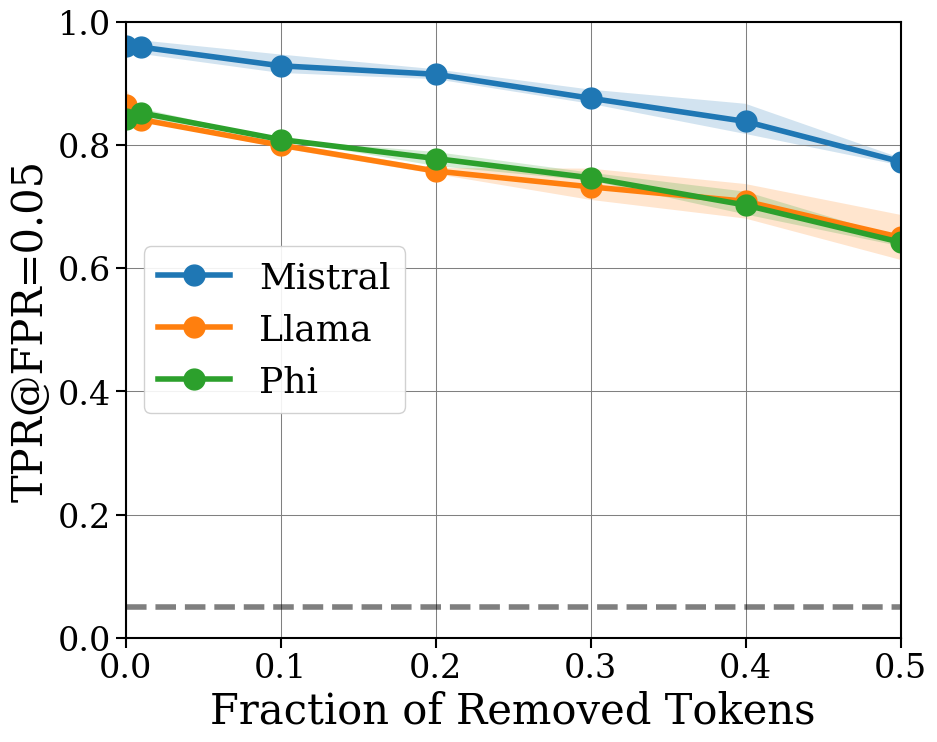

In [23]:

corruption_type = 'remove_start_tokens'


fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

    
    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"LowRank Removing Tokens from Prompt")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-remove-start-sig{sig_pval}.png'))

plt.show()

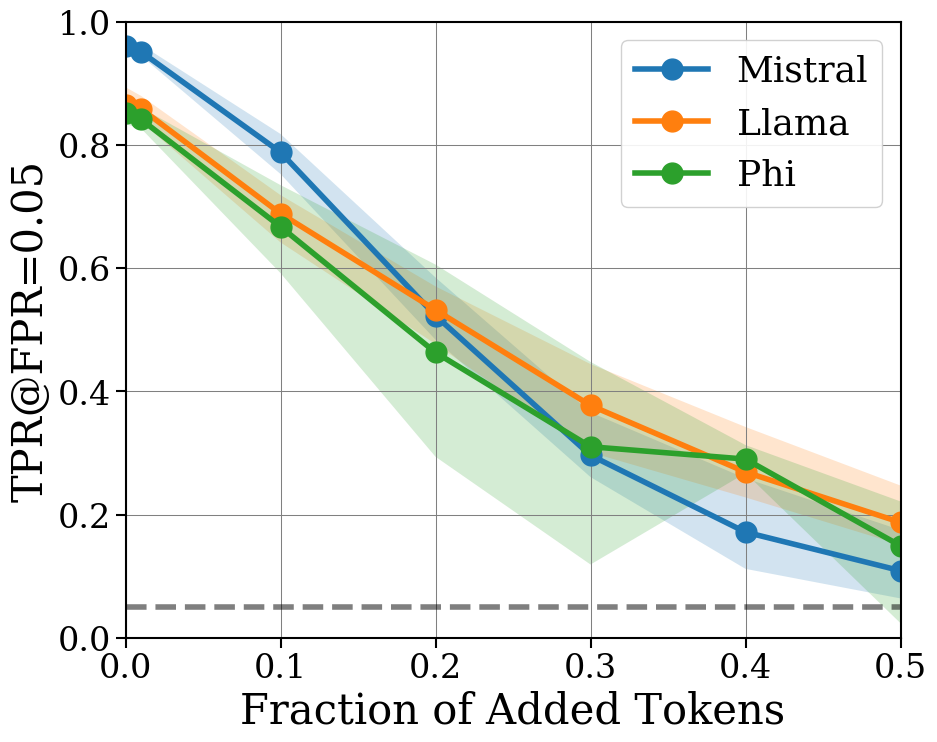

In [24]:

corruption_type = 'remove_random_tokens'


fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"LowRank Removing Random Tokens")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-remove-random-sig{sig_pval}.png'))

plt.show()

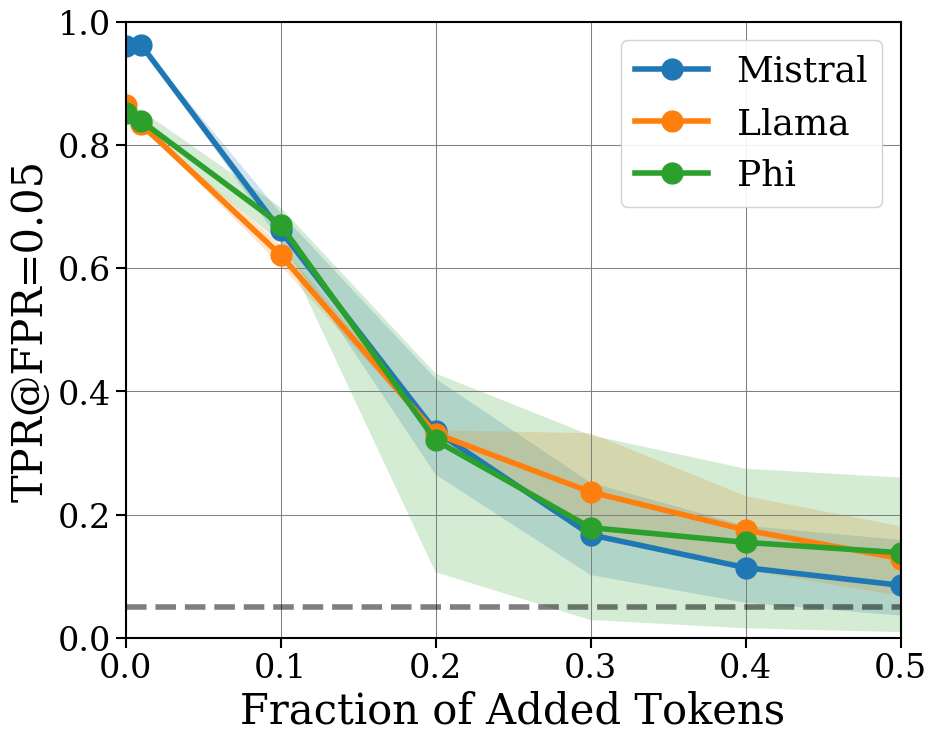

In [25]:

corruption_type = 'substitute_random_tokens'


fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"LowRank Substitute Random Tokens")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-substitute-random-sig{sig_pval}.png'))

plt.show()

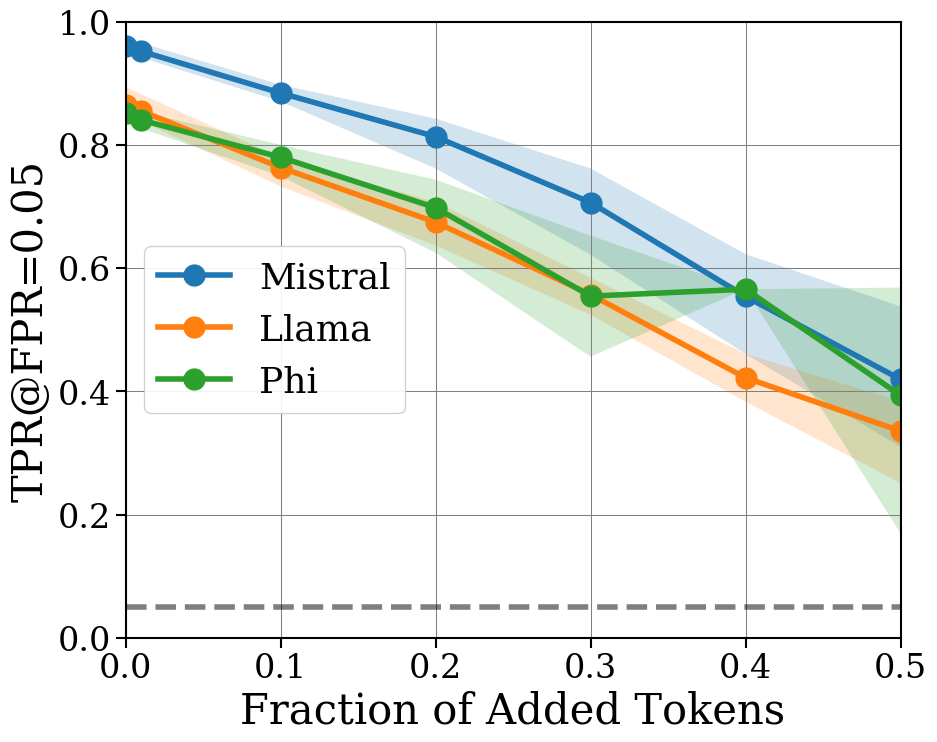

In [26]:

corruption_type = 'substitute_start_tokens'


fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    if 'Weak' in model:
        continue
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, num_passed = get_numtokens_numpassed(data_dict, sig_pval=sig_pval)

    lbs = [passed[0] for passed in num_passed]
    ubs = [passed[-1] for passed in num_passed]

    num_passed = [passed[1] for passed in num_passed]
    ax.plot(num_tokens, num_passed, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.axhline(sig_pval, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel(f"TPR@FPR={sig_pval}")
# fig.suptitle(f"LowRank Substitute Tokens in Prompt")


if save_figs:
    fig.savefig(os.path.join(figs_parent, f'corrupt-substitute-start-sig{sig_pval}.png'))

plt.show()

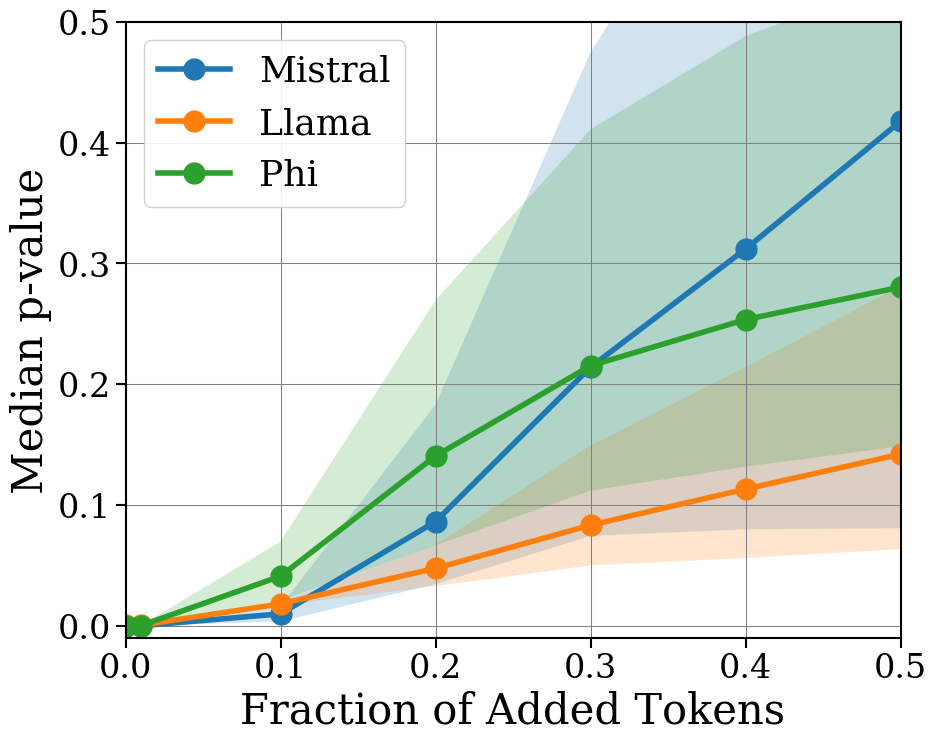

In [27]:
# corrupt_models = {
#     'Mistral': ('model.layers.20.mlp.up_proj.weight', 1e-05, 0), # ('model.layers.30.mlp.gate_proj.weight', 1e-05, 0), # ('model.layers.28.mlp.up_proj.weight', 1e-05, 0), #
#     'Llama': ('model.layers.28.mlp.up_proj.weight', 0.0003, 0), # ('model.layers.29.mlp.down_proj.weight', 0.0001, 0),
#     'Phi': ('model.layers.20.mlp.down_proj.weight', 0.001, 0)
# }
# corrupt_models = good_models

corruption_type = 'add_random_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel('Median p-value')
# fig.suptitle(f"LowRank Adding Random Tokens")


if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-add-random-weak.png'))

plt.show()

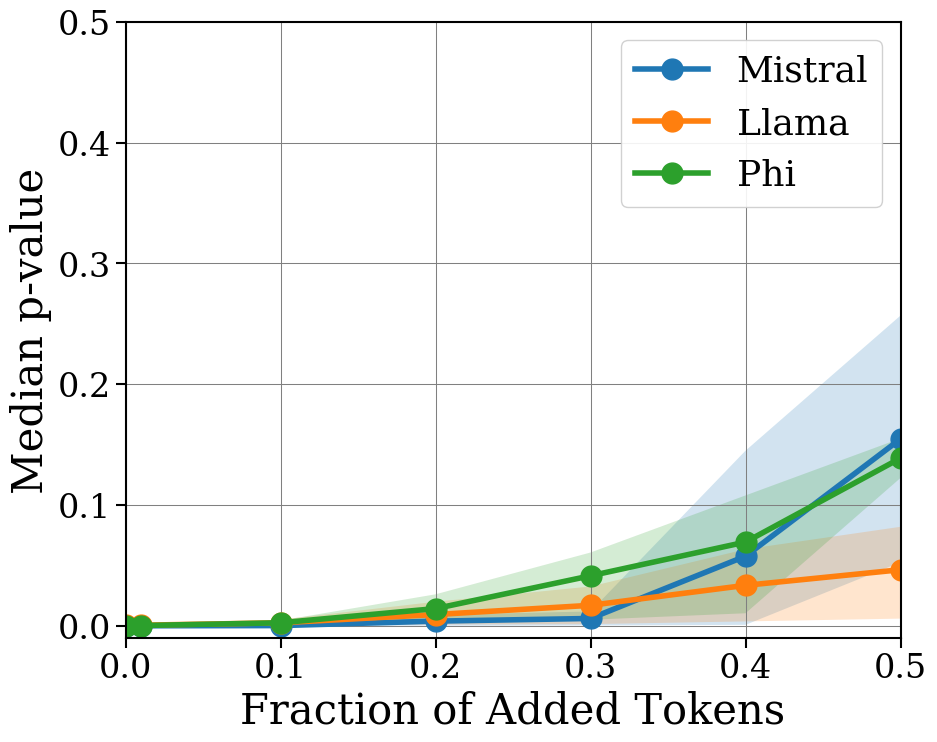

In [28]:
corruption_type = 'add_start_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel('Median p-value')
# fig.suptitle(f"LowRank Adding Tokens to Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-add-start-weak.png'))

plt.show()

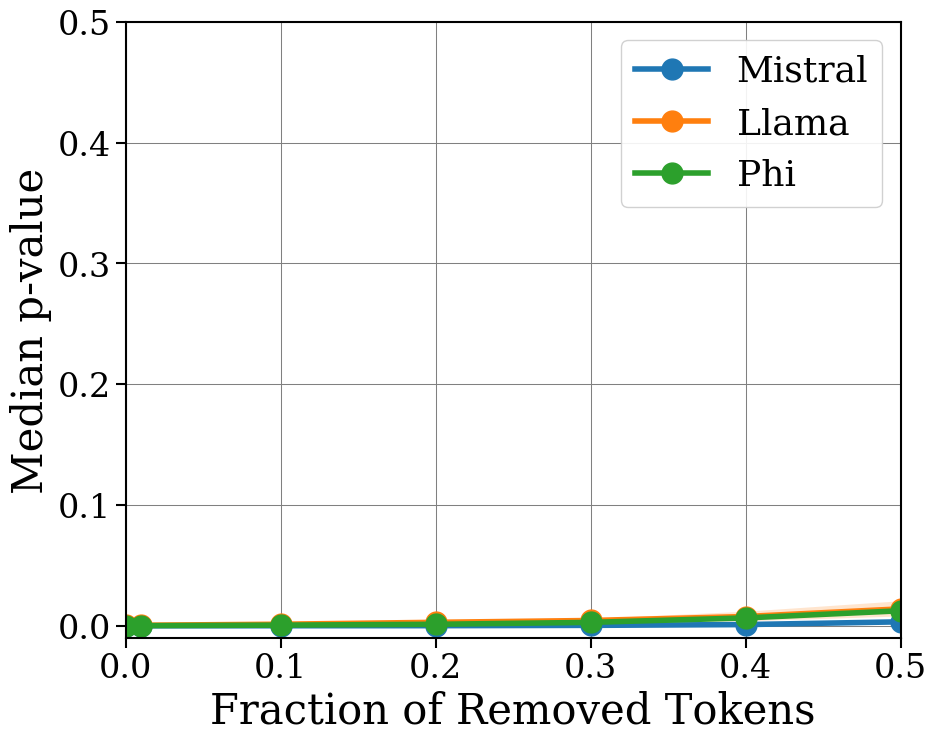

In [29]:
corruption_type = 'remove_start_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel('Median p-value')
# fig.suptitle(f"LowRank Removing Tokens from Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-remove-start-weak.png'))

plt.show()

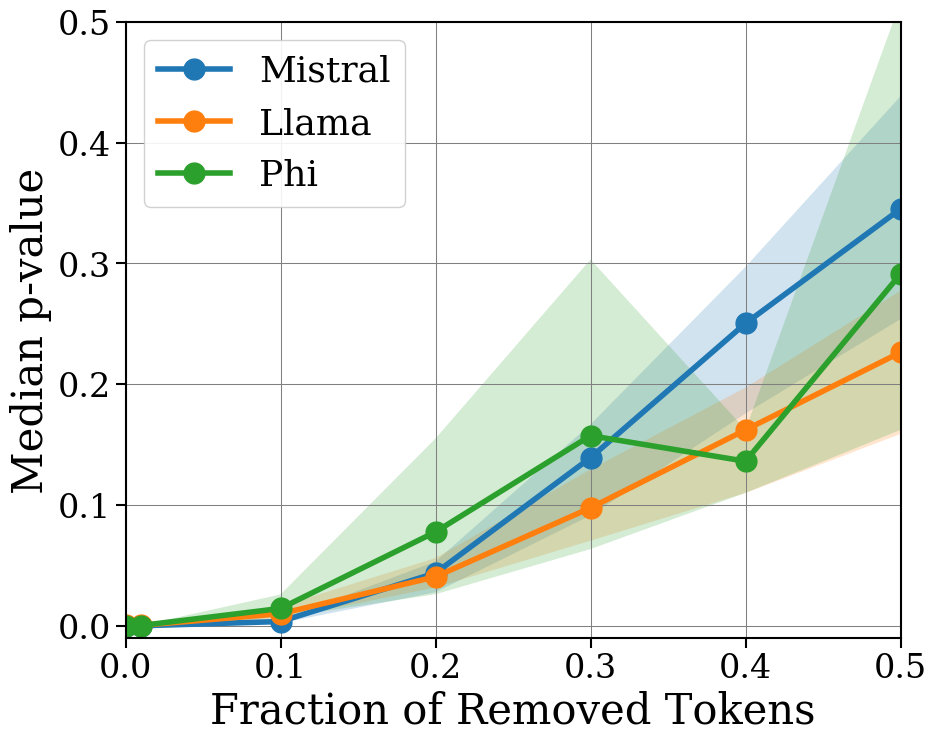

In [30]:
corruption_type = 'remove_random_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)


ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel('Median p-value')
# fig.suptitle(f"LowRank Removing Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-remove-random-weak.png'))

plt.show()

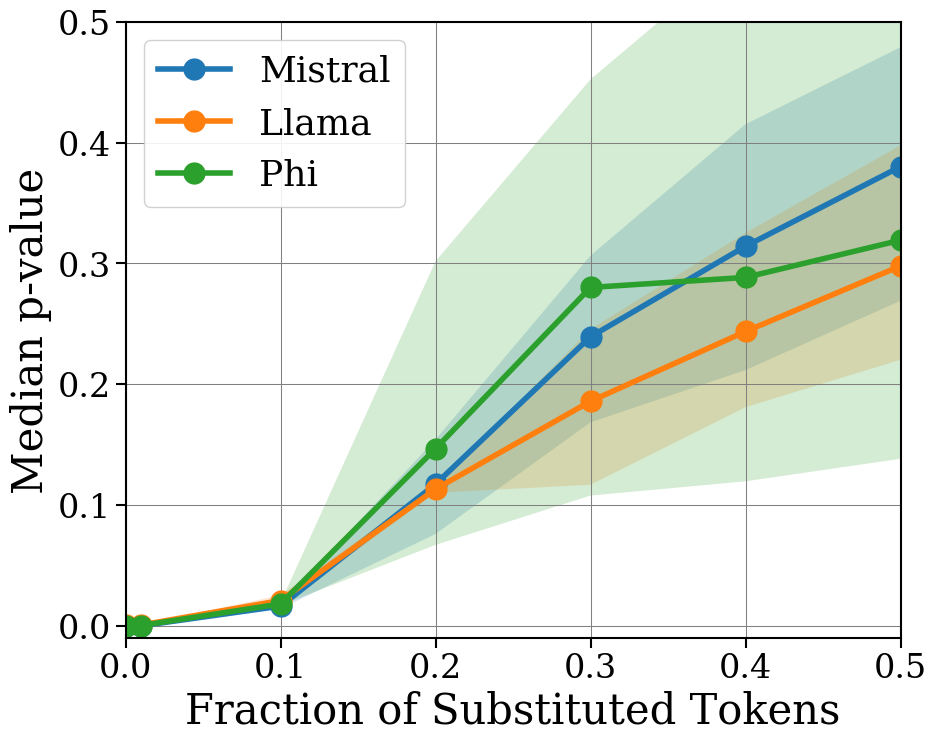

In [31]:
corruption_type = 'substitute_random_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel('Median p-value')
# fig.suptitle(f"LowRank Substituting Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-substitute-random-weak.png'))

plt.show()

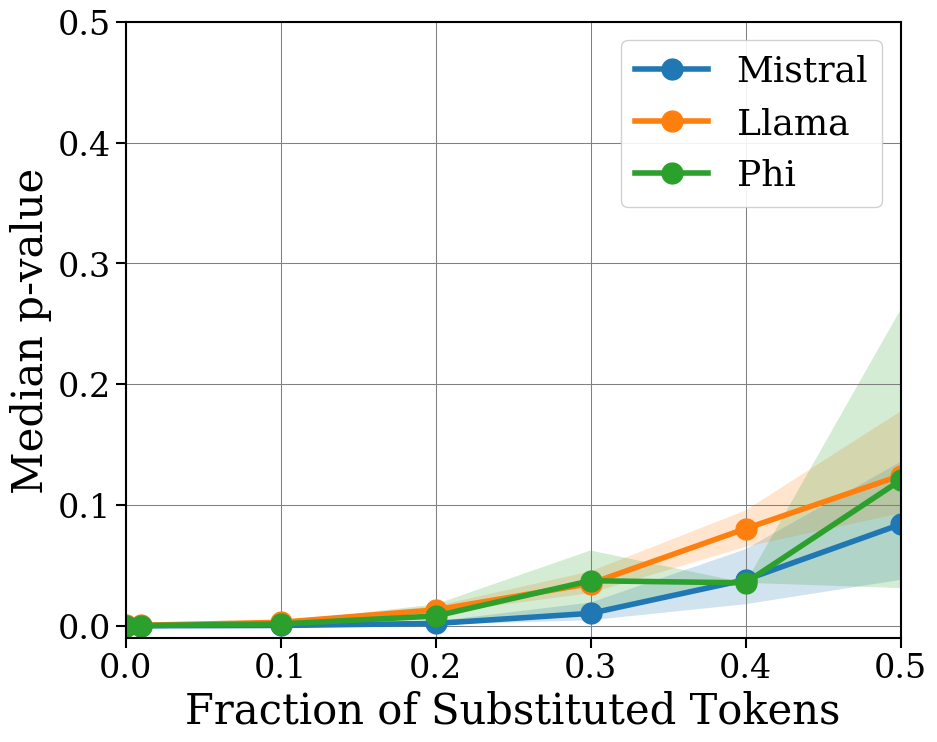

In [32]:
corruption_type = 'substitute_start_tokens'

min_quantile = 0.25
max_quantile = 0.75
fig, ax = plt.subplots()
for model, param in corrupt_models.items():
    if 'Weak' in model:
        continue
    # model_name = model_mappings[model]
    # data_dict = num_tokens_data[model_name][param]
    key = (param, model_mappings[model])

    data_dict = {numtok: get_corrupt_pvalues(corrupt_generations[key][corruption_type][numtok]) for numtok in corrupt_generations[key][corruption_type].keys()}

    num_tokens, medians, quantiles = get_nunmtokens_medians(data_dict, quantiles=[min_quantile, max_quantile])

    lbs = [median[0] for median in medians]
    ubs = [median[-1] for median in medians]
    medians = [median[1] for median in medians]


    # lbs  = [quantile[min_quantile] for quantile in quantiles]
    # ubs = [quantile[max_quantile] for quantile in quantiles]
    ax.plot(num_tokens, medians, label=model, marker='o')
    ax.fill_between(num_tokens, lbs, ubs, alpha=0.2)

ax.legend()
ax.set_ylim(-0.01, 0.5)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel('Median p-value')
# fig.suptitle(f"LowRank Substituting Tokens in Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'Fig-2-corrupt-substitute-start-weak.png'))

plt.show()

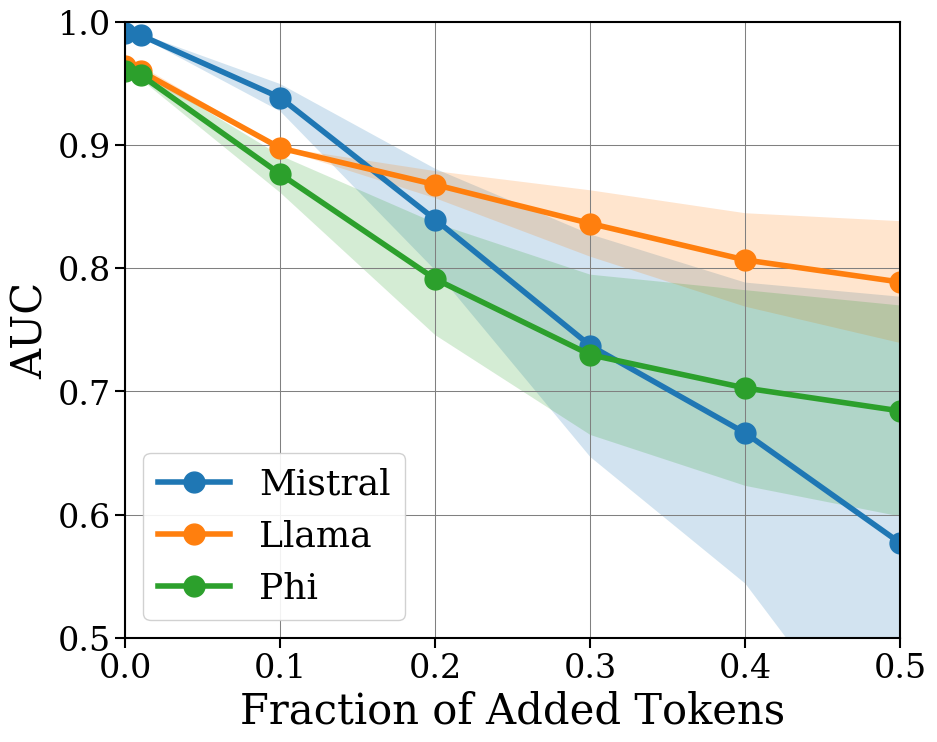

In [33]:
corruption_type = 'add_random_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel('AUC')
# fig.suptitle(f"Adding Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'corrupt-add-random-weak-auc.png'))

plt.show()



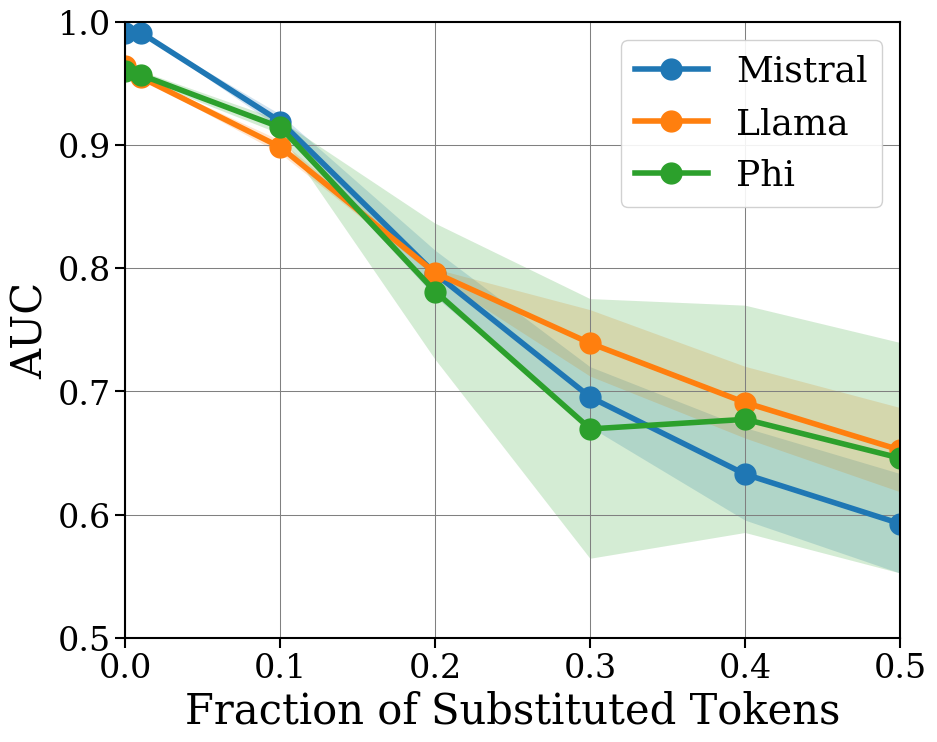

In [34]:
corruption_type = 'substitute_random_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel('AUC')
# fig.suptitle(f"Substituting Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'corrupt-substitute-random-weak-auc.png'))

plt.show()



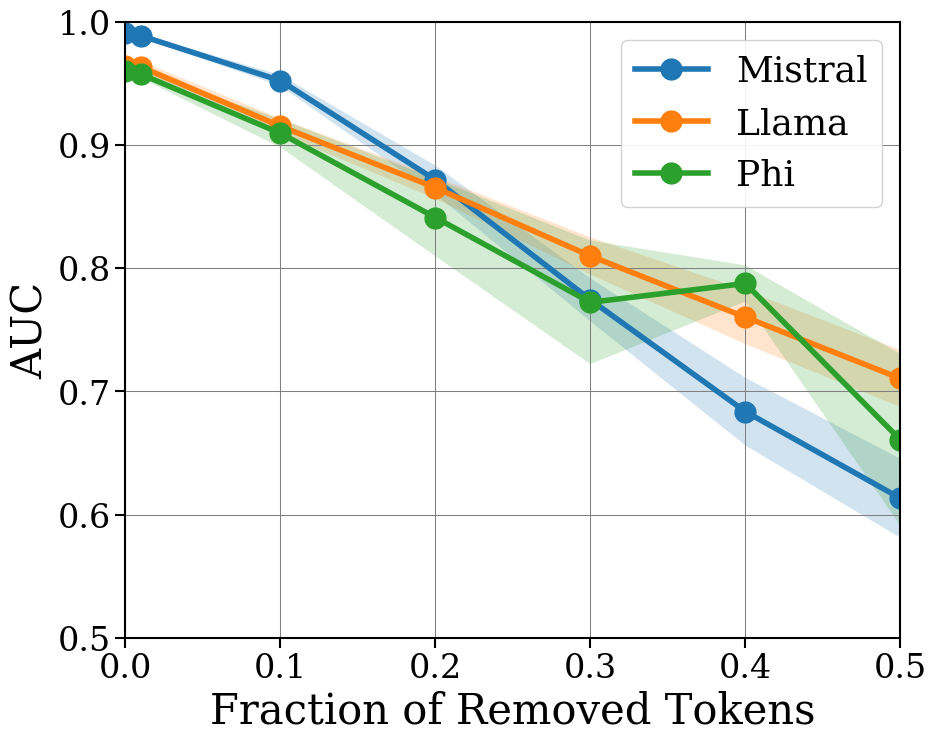

In [35]:
corruption_type = 'remove_random_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel('AUC')
# fig.suptitle(f"Removing Random Tokens")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'corrupt-remove-random-weak-auc.png'))

plt.show()



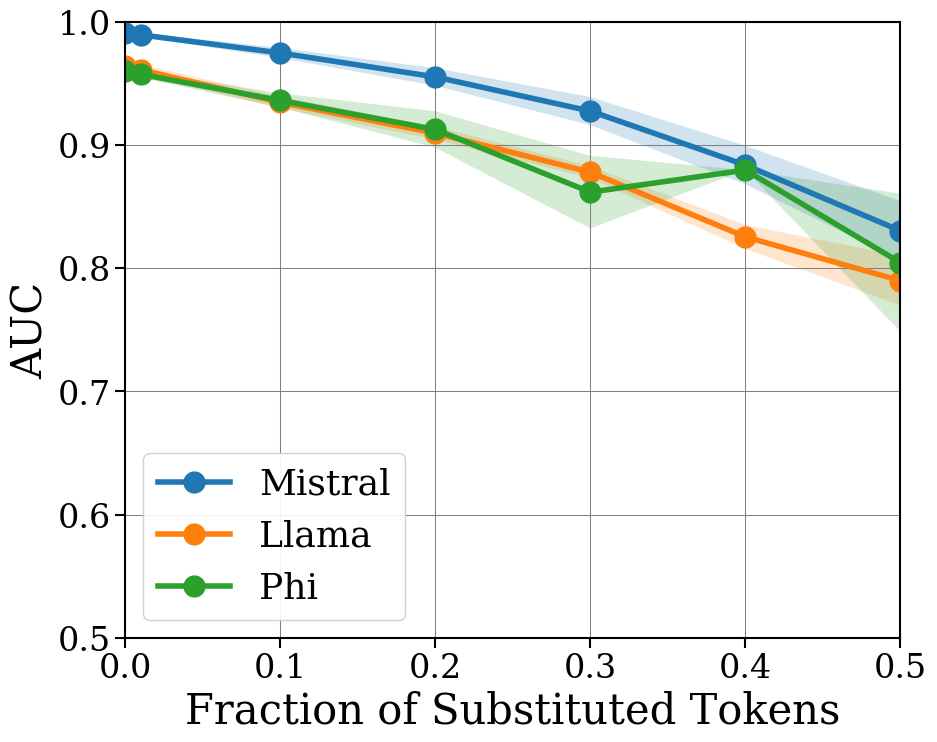

In [36]:
corruption_type = 'substitute_start_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Substituted Tokens')
ax.set_ylabel('AUC')
# fig.suptitle(f"Substituting Tokens in Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'corrupt-substitute-start-weak-auc.png'))

plt.show()



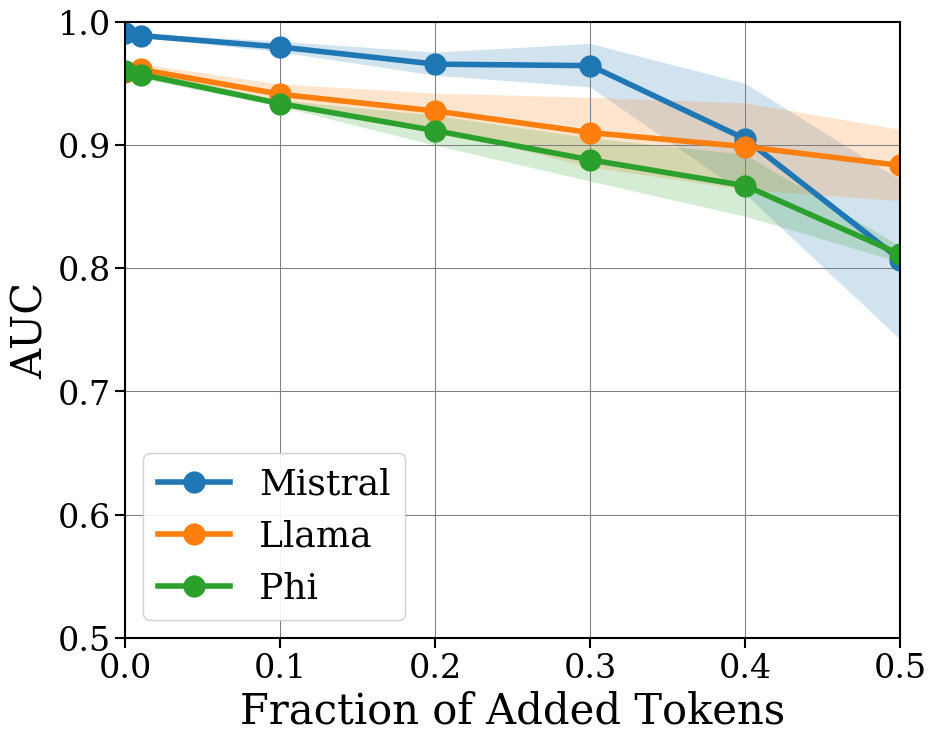

In [37]:
corruption_type = 'add_start_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Added Tokens')
ax.set_ylabel('AUC')
# fig.suptitle(f"Adding Tokens to Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'corrupt-add-start-weak-auc.png'))

plt.show()



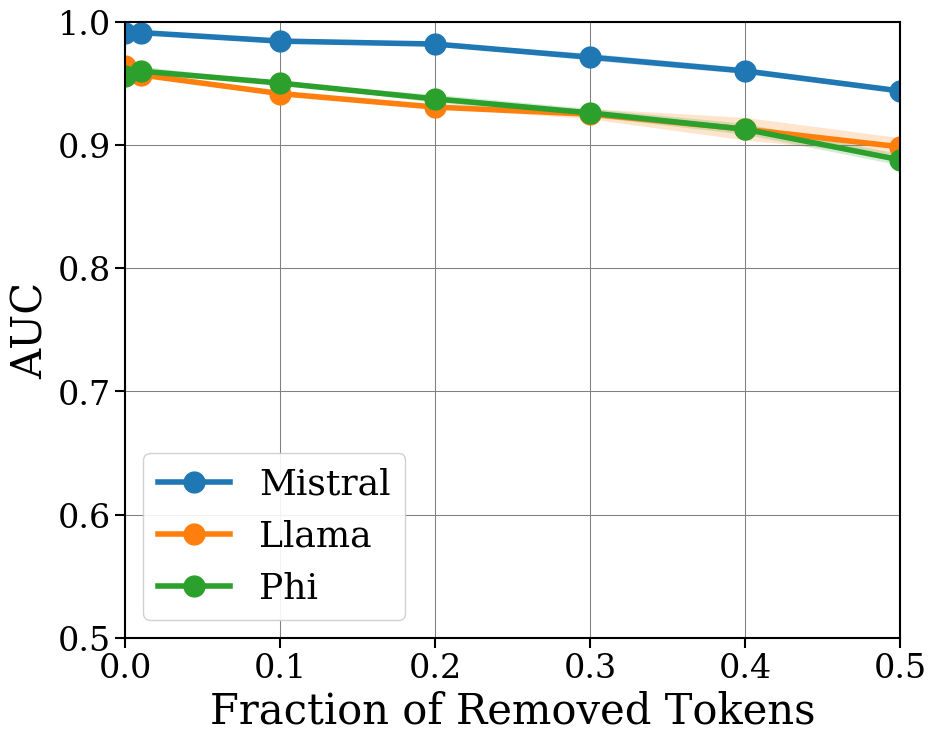

In [38]:
corruption_type = 'remove_start_tokens'

fig, ax = plt.subplots()
models = ['Mistral', 'Llama', 'Phi']
for model in models:



    model_name = model_mappings[model]
    param = good_models[model]
    model_key  = (param, model_mappings[model])
    temp_data = corrupt_generations[model_key]


    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    num_toks, aucs, std_errs = [], [], []
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        temp_aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            temp_aucs.append(auc)
        mean_auc, std_auc = np.mean(temp_aucs), np.std(temp_aucs)
        aucs.append(mean_auc)
        std_errs.append(std_auc / np.sqrt(len(temp_aucs)))
        num_toks.append(num_tokens)
    
    ax.plot(num_toks, aucs, label=model, marker='o')
    ax.fill_between(num_toks, np.array(aucs) - np.array(std_errs), np.array(aucs) + np.array(std_errs), alpha=0.2)

ax.legend()
ax.set_ylim(0.5, 1)
ax.set_xlabel('Fraction of Removed Tokens')
ax.set_ylabel('AUC')
# fig.suptitle(f"Removing Tokens from Prompt")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'corrupt-remove-start-weak-auc.png'))

plt.show()



# Roundtrip translation

In [39]:
parents = [
    '10-10-roundtrip-translation',
    '10-14-roundtrip-translation',
    '10-14-roundtrip-translation-mistral'
]
parents = [os.path.join(amlt_parent, parent) for parent in parents]



roundtrip_gens = get_roundtrip_translations(parents)


Skipping Mistral
Llama (corrupted) AUC: 0.6807
Llama (uncorrupted) AUC: 0.9766
Phi (corrupted) AUC: 0.7534
Phi (uncorrupted) AUC: 0.9602
Skipping MistralLowRank
Skipping LlamaLowRank
Skipping PhiLowRank


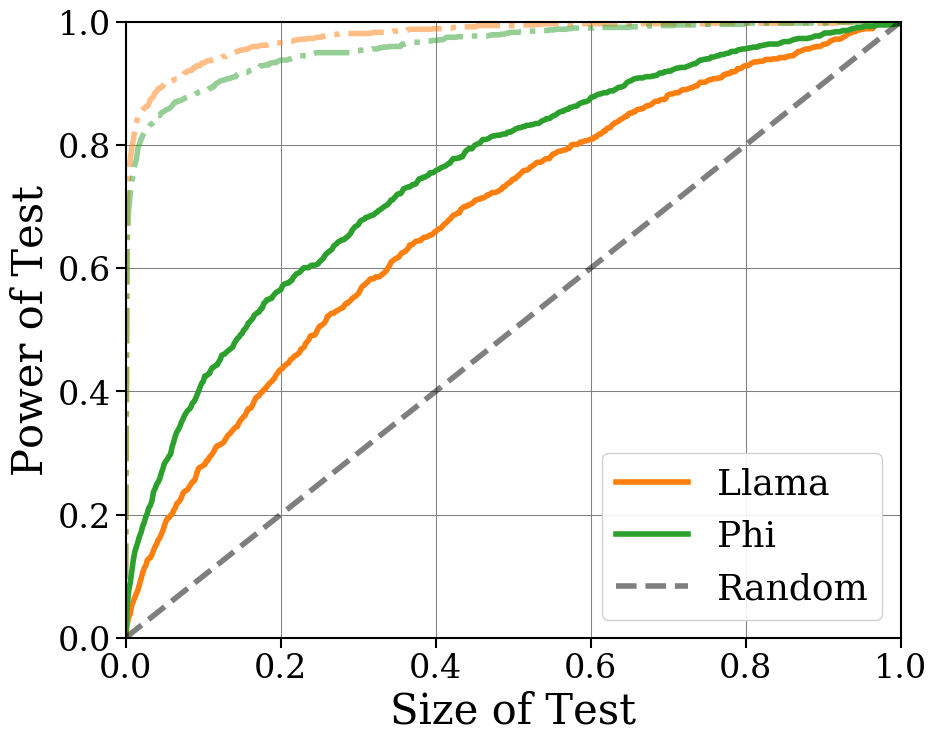

In [40]:


fig, ax = plt.subplots()

for i, model in enumerate(model_mappings.keys()):
    if "Weak" in model:
        continue
    try:
        model_name = model_mappings[model]
        key = (corrupt_models[model], model_name)
        roundtrip = roundtrip_gens[key]['roundtrip_translation']
        uncorrupted = roundtrip_gens[key]['uncorrupted']

        roundtrip = get_all(roundtrip, 1e-20)
        uncorrupted = get_all(uncorrupted, 1e-20)

        grid, cdf = get_empirical_cdf(roundtrip['pvalue'], grid_size=500)
        # ax.plot(grid, cdf, color=default_cycler[i], label=f"{model} (Corrupted)")
        ax.plot(grid, cdf, color=default_cycler[i], label=f"{model}")

        auc = get_auc(grid, cdf)
        print(f"{model} (corrupted) AUC: {auc:.4f}")

        grid, cdf = get_empirical_cdf(uncorrupted['pvalue'], grid_size=500)

        auc = get_auc(grid, cdf)
        print(f"{model} (uncorrupted) AUC: {auc:.4f}")
        # ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', label=f"{model} (Uncorrupted)", alpha=0.5)
        ax.plot(grid, cdf, color=default_cycler[i], linestyle='-.', alpha=0.5)
    except KeyError:
        print(f"Skipping {model}")
ax.plot(grid, grid, linestyle='--', alpha = 0.5, color='black', label='Random')
ax.legend()
ax.set_xlabel('Size of Test')
ax.set_ylabel('Power of Test')
ax.set_ylim(0, 1)

# fig.suptitle("ROC After Roundtrip Translation")

if save_figs:
    fig.savefig(os.path.join(figs_parent, 'roundtrip-translation-roc.png'))

plt.show()




# AUCs for Corrupted Text

In [41]:
model = 'Phi'


model_name = model_mappings[model]
param = good_models[model]
model_key  = (param, model_mappings[model])
temp_data = corrupt_generations[model_key]

corruption_types = [
    'add_random_tokens',
    'substitute_random_tokens',
    'remove_random_tokens',
    'substitute_start_tokens',
    'add_start_tokens',
    'remove_start_tokens'
]


print(f"Model: {model}")
for corruption_type in corruption_types:

    print(f"\nCorruption Type: {corruption_type}" + '#' * 50)
    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            aucs.append(auc)
        mean_auc, std_auc = np.mean(aucs), np.std(aucs)
        print(f"{num_tokens} Corrupted tokens AUC: {mean_auc:.4f} +/- {std_auc:.4f}")





Model: Phi

Corruption Type: add_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9599 +/- 0.0056
0.01 Corrupted tokens AUC: 0.9567 +/- 0.0059
0.1 Corrupted tokens AUC: 0.8764 +/- 0.0261
0.2 Corrupted tokens AUC: 0.7912 +/- 0.0788
0.3 Corrupted tokens AUC: 0.7297 +/- 0.1127
0.4 Corrupted tokens AUC: 0.7028 +/- 0.1375
0.5 Corrupted tokens AUC: 0.6842 +/- 0.1483

Corruption Type: substitute_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9599 +/- 0.0056
0.01 Corrupted tokens AUC: 0.9569 +/- 0.0053
0.1 Corrupted tokens AUC: 0.9144 +/- 0.0080
0.2 Corrupted tokens AUC: 0.7811 +/- 0.0956
0.3 Corrupted tokens AUC: 0.6696 +/- 0.1491
0.4 Corrupted tokens AUC: 0.6774 +/- 0.1598
0.5 Corrupted tokens AUC: 0.6458 +/- 0.1620

Corruption Type: remove_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9599 +/- 0.0056
0.01 Corrupted tokens AUC: 0.9575 +/- 0.0055
0.1 Corrupted 

In [42]:
model = 'Mistral'


model_name = model_mappings[model]
param = good_models[model]
model_key  = (param, model_mappings[model])
temp_data = corrupt_generations[model_key]

corruption_types = [
    'add_random_tokens',
    'substitute_random_tokens',
    'remove_random_tokens',
    'substitute_start_tokens',
    'add_start_tokens',
    'remove_start_tokens'
]


print(f"Model: {model}")
for corruption_type in corruption_types:

    print(f"\nCorruption Type: {corruption_type}" + '#' * 50)
    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            aucs.append(auc)
        mean_auc, std_auc = np.mean(aucs), np.std(aucs)
        print(f"{num_tokens} Corrupted tokens AUC: {mean_auc:.4f} +/- {std_auc:.4f}")





Model: Mistral

Corruption Type: add_random_tokens##################################################


0.0 Corrupted tokens AUC: 0.9910 +/- 0.0022
0.01 Corrupted tokens AUC: 0.9891 +/- 0.0023
0.1 Corrupted tokens AUC: 0.9384 +/- 0.0157
0.2 Corrupted tokens AUC: 0.8395 +/- 0.0714
0.3 Corrupted tokens AUC: 0.7371 +/- 0.1565
0.4 Corrupted tokens AUC: 0.6662 +/- 0.2116
0.5 Corrupted tokens AUC: 0.5769 +/- 0.2829

Corruption Type: substitute_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9910 +/- 0.0022
0.01 Corrupted tokens AUC: 0.9913 +/- 0.0000
0.1 Corrupted tokens AUC: 0.9190 +/- 0.0099
0.2 Corrupted tokens AUC: 0.7955 +/- 0.0326
0.3 Corrupted tokens AUC: 0.6953 +/- 0.0423
0.4 Corrupted tokens AUC: 0.6328 +/- 0.0650
0.5 Corrupted tokens AUC: 0.5926 +/- 0.0700

Corruption Type: remove_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9910 +/- 0.0022
0.01 Corrupted tokens AUC: 0.9887 +/- 0.0022
0.1 Corrupted tokens AUC: 0.9523 +/- 0.0077
0.2 Corrupted tokens AUC: 0.8717 +/- 0.0202
0.3 Corrupted tokens AU

In [43]:
model = 'Llama'


model_name = model_mappings[model]
param = good_models[model]
model_key  = (param, model_mappings[model])
temp_data = corrupt_generations[model_key]

corruption_types = [
    'add_random_tokens',
    'substitute_random_tokens',
    'remove_random_tokens',
    'substitute_start_tokens',
    'add_start_tokens',
    'remove_start_tokens'
]


print(f"Model: {model}")
for corruption_type in corruption_types:

    print(f"\nCorruption Type: {corruption_type}" + '#' * 50)
    temp_data_sorted = {key: temp_data[corruption_type][key] for key in sorted(temp_data[corruption_type].keys())}
    for num_tokens, temp_datum in temp_data_sorted.items():
        
        aucs = []
        for seed, datum in temp_datum.items():
            datum = pd.DataFrame(datum)
            grid, cdf = get_empirical_cdf(datum['pvalue'], grid_size=500)
            auc = get_auc(grid, cdf)
            aucs.append(auc)
        mean_auc, std_auc = np.mean(aucs), np.std(aucs)
        print(f"{num_tokens} Corrupted tokens AUC: {mean_auc:.4f} +/- {std_auc:.4f}")





Model: Llama

Corruption Type: add_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9640 +/- 0.0066
0.01 Corrupted tokens AUC: 0.9598 +/- 0.0076
0.1 Corrupted tokens AUC: 0.8975 +/- 0.0009
0.2 Corrupted tokens AUC: 0.8678 +/- 0.0191
0.3 Corrupted tokens AUC: 0.8363 +/- 0.0467
0.4 Corrupted tokens AUC: 0.8067 +/- 0.0657
0.5 Corrupted tokens AUC: 0.7888 +/- 0.0856

Corruption Type: substitute_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9640 +/- 0.0066
0.01 Corrupted tokens AUC: 0.9549 +/- 0.0009
0.1 Corrupted tokens AUC: 0.8983 +/- 0.0075
0.2 Corrupted tokens AUC: 0.7962 +/- 0.0043
0.3 Corrupted tokens AUC: 0.7391 +/- 0.0467
0.4 Corrupted tokens AUC: 0.6909 +/- 0.0504
0.5 Corrupted tokens AUC: 0.6524 +/- 0.0592

Corruption Type: remove_random_tokens##################################################
0.0 Corrupted tokens AUC: 0.9640 +/- 0.0066
0.01 Corrupted tokens AUC: 0.9634 +/- 0.0066
0.1 Corrupte

# Metrics

In [44]:
llama_parent = os.path.join(amlt_parent, '10-10-watermark-llama-lowrank')


llama_generations = get_generations(llama_parent)['meta-llama/Meta-Llama-3.1-8B']
llama_metrics = get_metrics(llama_parent, include_unwatermarked=False)['meta-llama/Meta-Llama-3.1-8B']
llama_unwatermarked = get_unwatermarked_metrics('meta-llama/Meta-Llama-3.1-8B')[0]
llama_data = {key: get_all(llama_generations[key], 1e-20) for key in llama_generations.keys()}

phi_parent = os.path.join(amlt_parent, '10-10-watermark-phi-lowrank')


phi_generations = get_generations(phi_parent)['microsoft/Phi-3-mini-4k-instruct']
phi_metrics = get_metrics(phi_parent, include_unwatermarked=False)['microsoft/Phi-3-mini-4k-instruct']
phi_unwatermarked = get_unwatermarked_metrics('microsoft/Phi-3-mini-4k-instruct')[0]
phi_data = {key: get_all(phi_generations[key], 1e-20) for key in phi_generations.keys()}


mistral_parent = os.path.join(amlt_parent, '10-10-watermark-mistral-lowrank')

mistral_generations = get_generations(mistral_parent)['mistralai/Mistral-7B-v0.3']
mistral_metrics = get_metrics(mistral_parent, include_unwatermarked=False)['mistralai/Mistral-7B-v0.3']
mistral_unwatermarked = get_unwatermarked_metrics('mistralai/Mistral-7B-v0.3')[0]
mistral_data = {key: get_all(mistral_generations[key], 1e-20) for key in mistral_generations.keys()}

[Errno 2] No such file or directory: '/home/blockadam/gaussian-watermarking/amlt/10-10-watermark-llama-lowrank/grid_10-10-watermark-llama-lowrank_lay_30_mlp_gate_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_1024_var_3e-5/generations.json'
Error processing /home/blockadam/gaussian-watermarking/amlt/10-10-watermark-llama-lowrank/grid_10-10-watermark-llama-lowrank_lay_30_mlp_gate_proj_mod_meta-llama_Meta-Llama-3.1-8B_ran_1024_var_3e-5
[Errno 2] No such file or directory: '/home/blockadam/gaussian-watermarking/amlt/10-10-watermark-phi-lowrank/grid_10-10-watermark-phi-lowrank_lay_30_mlp_gate_up_proj_mod_microsoft_Phi-3-mini-4k-instruct_ran_1024_var_3e-4/generations.json'
Error processing /home/blockadam/gaussian-watermarking/amlt/10-10-watermark-phi-lowrank/grid_10-10-watermark-phi-lowrank_lay_30_mlp_gate_up_proj_mod_microsoft_Phi-3-mini-4k-instruct_ran_1024_var_3e-4
[Errno 2] No such file or directory: '/home/blockadam/gaussian-watermarking/amlt/10-10-watermark-phi-lowrank/grid_10-10-watermar

In [45]:
def get_avg_metrics(model):
    if 'Phi' in model:
        metric = phi_metrics[good_models[model]]
    elif 'LlamaWeak' in model:
        metric = llama_metrics[good_models[model]]
    elif 'Mistral' in model:
        metric = mistral_metrics[good_models[model]]
    elif 'Llama' in model:
        metric = llama_metrics[good_models[model]]
    
    superglue_avg, superglue_stderr = [], []
    for key in metric.keys():
        if key == 'gsm8k_cot_self_consistency':
            continue
        if key == 'record':
            superglue_avg.append(metric[key]['f1'])
            superglue_stderr.append(metric[key]['f1_stderr']**2)
        else:
            superglue_avg.append(metric[key]['acc'])
            superglue_stderr.append(metric[key]['acc_stderr']**2)
    
    print(f"{model}: Superglue {np.mean(superglue_avg):.4f} $\\pm$ {np.sqrt(np.mean((superglue_stderr))):.4f}")
    gsm8k_acc = metric['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
    gsm8k_acc_stderr = metric['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']
    print(f"{model}: GSM8K {gsm8k_acc:.4f} $\\pm$ {gsm8k_acc_stderr:.4f}")

In [46]:
get_avg_metrics('Mistral')
get_avg_metrics('Phi')
get_avg_metrics('Llama')


Mistral: Superglue 0.6796 $\pm$ 0.0336
Mistral: GSM8K 0.4253 $\pm$ 0.0136
Phi: Superglue 0.6384 $\pm$ 0.0258
Phi: GSM8K 0.8537 $\pm$ 0.0097
Llama: Superglue 0.6992 $\pm$ 0.0337
Llama: GSM8K 0.6133 $\pm$ 0.0134


# Base Model Generations

In [47]:
def get_base_generations():
    base_generations_parent = '/home/blockadam/gaussian-watermarking/base_generations'
    base_generations = {}
    with open(os.path.join(base_generations_parent, 'phi_generations.json'), 'r') as f:
        base_generations['microsoft/Phi-3-mini-4k-instruct'] = pd.DataFrame(json.load(f))
    with open(os.path.join(base_generations_parent, 'mistral_generations.json'), 'r') as f:
        base_generations['mistralai/Mistral-7B-v0.3'] = pd.DataFrame(json.load(f))
    with open(os.path.join(base_generations_parent, 'llama_generations.json'), 'r') as f:
        base_generations['meta-llama/Meta-Llama-3.1-8B'] = pd.DataFrame(json.load(f))
    return base_generations

base_generations = get_base_generations()

In [48]:
base_generations['microsoft/Phi-3-mini-4k-instruct']

,prompt,prompt_token_ids,response,response_token_ids,logprobs
0,\n <|system|>\n You are a helpful assist...,"[29871, 13, 268, 32006, 887, 526, 263, 8444, 2...",for the spread of Christianity and defended t...,"[363, 278, 9677, 310, 6111, 537, 322, 822, 276...",-84.719968
1,\n <|system|>\n You are a helpful assist...,"[29871, 13, 268, 32006, 887, 526, 263, 8444, 2...","ins didn't hesitate to volunteer.\nAt 19, Butl...","[1144, 3282, 29915, 29873, 19066, 10388, 304, ...",-944.250678
2,\n <|system|>\n You are a helpful assist...,"[29871, 13, 268, 32006, 887, 526, 263, 8444, 2...",esthat emphasizes its unique and immersive vie...,"[342, 2455, 19310, 7093, 967, 5412, 322, 5198,...",-258.916128
3,\n <|system|>\n You are a helpful assist...,"[29871, 13, 268, 32006, 887, 526, 263, 8444, 2...",... to locate an office and build a delivery c...,"[856, 304, 26694, 385, 8034, 322, 2048, 263, 2...",-432.144387
4,\n <|system|>\n You are a helpful assist...,"[29871, 13, 268, 32006, 887, 526, 263, 8444, 2...",elling cybersecurity and technology solutions ...,"[7807, 5094, 495, 8926, 322, 15483, 6851, 4822...",-131.064039
...,...,...,...,...,...
995,\n <|system|>\n You are a helpful assist...,"[29871, 13, 268, 32006, 887, 526, 263, 8444, 2...",cers (formerly known as IES) has been respondi...,"[22543, 313, 24784, 368, 2998, 408, 306, 2890,...",-749.613221
996,\n <|system|>\n You are a helpful assist...,"[29871, 13, 268, 32006, 887, 526, 263, 8444, 2...",citizens to not let their guard down against ...,"[18363, 304, 451, 1235, 1009, 8372, 1623, 2750...",-339.417178
997,\n <|system|>\n You are a helpful assist...,"[29871, 13, 268, 32006, 887, 526, 263, 8444, 2...",den. The senior paramedic and volunteer firefi...,"[1145, 29889, 450, 16336, 1828, 7486, 322, 278...",-679.960798
998,\n <|system|>\n You are a helpful assist...,"[29871, 13, 268, 32006, 887, 526, 263, 8444, 2...",10-character ensemble drama and will also star...,"[29896, 29900, 29899, 18609, 21285, 18621, 322...",-1564.109657


In [49]:
def print_generations(model, num_tokens=1000, seed=1761, idx=None, return_data=False):
    if idx is None:
        idx = np.random.randint(0, 1000)
    
    base_row = base_generations[model_mappings[model]].iloc[idx]
    prompt = base_row['prompt']
    base_answer = base_row['response']

    watermarked_row = num_tokens_generations[model_mappings[model]][good_models[model]][num_tokens][seed][idx]
    watermarked_answer = watermarked_row['response']
    pvalue = watermarked_row['pvalue']

    if not return_data:
        print(f"({idx}) pvalue: {pvalue:.4f}")
        print("Prompt: " + '#'*50 )
        print(prompt)
        print('\n')
        print(f"Base Answer: " + '#'*50 )
        print(base_answer)
        print('\n')
        print(f"Watermarked Answer: " + '#'*50 )
        print(watermarked_answer)

    if return_data:
        return dict(base_row), watermarked_row


In [50]:
# idx = 632
# idx = 267
# idx = 341
idx = None
if idx is None:
    idx = np.random.randint(0, 1000)
print_generations('Phi', idx=idx)

(261) pvalue: 0.1003
Prompt: ##################################################

    <|system|>
    You are a helpful assistant.<|end|>
    <|user|>
    Complete the following prompt:<|end|>
    <|assistant|>

    Apple's new Music Memos app captures musical inspiration, while GarageBand adds a new AI drummer and


Base Answer: ##################################################
 offers collaborative online sessions. IonMusic brings the complete Sony music library to iOS devices.

Which of the above updates should you consider implementing first for your music production business, and why?


Watermarked Answer: ##################################################
 unique audio effects.


In [51]:
print_generations('Mistral', idx=idx)

(261) pvalue: 0.0000
Prompt: ##################################################
Apple's new Music Memos app captures musical inspiration, while GarageBand adds a new AI drummer and


Base Answer: ##################################################
 simplifies its piano roll editor. Both apps have new share options for sending audio and MIDI data to other users, and both have been redesigned for iOS 10.

When you're on the go and inspiration strikes, fire up Music Memos and record your idea. It automatically analyzes your recording and generates a chord chart that matches your music, complete with all the chords you play.

When you return to your Mac and iTunes, all of your ideas and chords charts will be synced through iCloud. No matter where you go, your musical ideas are with you.

Apple's new Drummer AI takes live performance to a new level with Machine Learning. It actually learns the way you play by analyzing your style. Drummer provides intelligent variations, so every song you cr

In [52]:
print_generations('Llama', idx=idx)

(261) pvalue: 0.0000
Prompt: ##################################################
Apple's new Music Memos app captures musical inspiration, while GarageBand adds a new AI drummer and


Base Answer: ##################################################
 guitar amp and effects emulators.
At WWDC, Apple announced Music Memos, a new app designed for capturing and building musical ideas. It is, in a sense, a new music-input device for the iPhone. The app is available now for free in the App Store, and includes both multi-track recording, audio file import and free-form pencil sketching.
In the App Store, Apple has the Pitch app, which provides a visual representation of the pitch of a musical note, and it has Voice Record, which records a voice memo, so it's an interesting combination of these two ideas.
Music Memos provides a minimal user interface: tap the record button and start singing or playing an instrument. When the app thinks it has identified the pitch of the note, it will show the not

In [53]:
idxs = {
    632, 267, 341, 244, 767, 704, 866, 4
}

sample_generations = {}
for model in model_mappings.keys():
    if 'Weak' in model or 'LowRank' in model:
        continue
    sample_generations[model] = {}
    base_gens, watermarked_gens = [], []
    for idx in idxs:
        base_row, watermarked_row = print_generations(model, idx=idx, return_data=True)
        base_gens.append(base_row)
        watermarked_gens.append(watermarked_row)
    
    sample_generations[model]['base'] = base_gens
    sample_generations[model]['watermarked'] = watermarked_gens



In [54]:
with open('data/sample_generations.json', 'w') as f:
    json.dump(sample_generations, f)

# Good models DF

In [55]:
good_models_df = pd.read_csv('good_models.csv')
print(good_models_df.shape)
good_models_df = add_win_rates(good_models_df)

(148, 6)


In [56]:
def get_avg_metrics(model):
    if 'Phi' in model:
        metric = phi_metrics[good_models[model]]
    elif 'LlamaWeak' in model:
        metric = llama_metrics[good_models[model]]
    elif 'Mistral' in model:
        metric = mistral_metrics[good_models[model]]
    elif 'Llama' in model:
        metric = llama_metrics[good_models[model]]
    
    superglue_avg, superglue_stderr = [], []
    for key in metric.keys():
        if key == 'gsm8k_cot_self_consistency':
            continue
        if key == 'record':
            superglue_avg.append(metric[key]['f1'])
            superglue_stderr.append(metric[key]['f1_stderr']**2)
        else:
            superglue_avg.append(metric[key]['acc'])
            superglue_stderr.append(metric[key]['acc_stderr']**2)
    
    print(f"{model}: Superglue {np.mean(superglue_avg):.4f} $\\pm$ {np.sqrt(np.mean((superglue_stderr))):.4f}")
    gsm8k_acc = metric['gsm8k_cot_self_consistency']['exact_match,flexible-extract']
    gsm8k_acc_stderr = metric['gsm8k_cot_self_consistency']['exact_match,flexible-extract_stderr']
    print(f"{model}: GSM8K {gsm8k_acc:.4f} $\\pm$ {gsm8k_acc_stderr:.4f}")

In [57]:
get_avg_metrics('Llama')
get_avg_metrics('Mistral')
get_avg_metrics('Phi')

Llama: Superglue 0.6992 $\pm$ 0.0337
Llama: GSM8K 0.6133 $\pm$ 0.0134
Mistral: Superglue 0.6796 $\pm$ 0.0336
Mistral: GSM8K 0.4253 $\pm$ 0.0136
Phi: Superglue 0.6384 $\pm$ 0.0258
Phi: GSM8K 0.8537 $\pm$ 0.0097


In [58]:
for alias in good_models.keys():
    row_idx = row_lookup[(good_models[alias], model_mappings[alias])]
    print(f"{alias}: Row {row_idx}, Watermark Overrides {good_models_df.loc[row_idx, 'watermark_overrides']}, win rate {good_models_df.loc[row_idx, 'win_rate']}")

Mistral: Row 110, Watermark Overrides mistralai/Mistral-7B-v0.3@___@1024@___@30@@@up_proj@@@weight@___@1e-05, win rate 0.45671267252195735
Llama: Row 79, Watermark Overrides meta-llama/Meta-Llama-3.1-8B@___@512@___@29@@@down_proj@@@weight@___@0.0001, win rate 0.49104859335038364
Phi: Row 105, Watermark Overrides microsoft/Phi-3-mini-4k-instruct@___@1024@___@31@@@gate_up_proj@@@weight@___@0.0003, win rate 0.4894409937888199


In [59]:
good_models_df

,watermark_overrides,exp_name,run_name,frac_passed,laserized,win_rate,baseline_mean,baseline_std
0,meta-llama/Meta-Llama-3.1-8B@___@0@___@20@@@do...,10-07-watermark-llama,grid_10-07-watermark-llama_lay_20_mlp_down_pro...,0.969,False,0.398734,0.407219,0.039590
1,meta-llama/Meta-Llama-3.1-8B@___@0@___@28@@@up...,10-07-watermark-llama,grid_10-07-watermark-llama_lay_28_mlp_up_proj_...,0.967,False,0.451654,0.407219,0.039590
2,meta-llama/Meta-Llama-3.1-8B@___@0@___@20@@@up...,10-07-watermark-llama,grid_10-07-watermark-llama_lay_20_mlp_up_proj_...,0.965,False,0.434227,0.407219,0.039590
3,meta-llama/Meta-Llama-3.1-8B@___@0@___@25@@@do...,10-07-watermark-llama,grid_10-07-watermark-llama_lay_25_mlp_down_pro...,0.954,False,0.453503,0.407219,0.039590
4,meta-llama/Meta-Llama-3.1-8B@___@0@___@30@@@do...,10-07-watermark-llama,grid_10-07-watermark-llama_lay_30_mlp_down_pro...,0.945,False,0.441624,0.407219,0.039590
...,...,...,...,...,...,...,...,...
143,mistralai/Mistral-7B-v0.3@___@1024@___@28@@@ga...,10-10-watermark-mistral-lowrank,grid_10-10-watermark-mistral-lowrank_lay_28_ml...,0.862,False,0.476612,0.493447,0.009053
144,mistralai/Mistral-7B-v0.3@___@64@___@28@@@gate...,10-10-watermark-mistral-lowrank,grid_10-10-watermark-mistral-lowrank_lay_28_ml...,0.861,False,0.447799,0.493447,0.009053
145,mistralai/Mistral-7B-v0.3@___@512@___@28@@@gat...,10-10-watermark-mistral-lowrank,grid_10-10-watermark-mistral-lowrank_lay_28_ml...,0.854,False,0.460076,0.493447,0.009053
146,mistralai/Mistral-7B-v0.3@___@128@___@28@@@gat...,10-10-watermark-mistral-lowrank,grid_10-10-watermark-mistral-lowrank_lay_28_ml...,0.846,False,0.456384,0.493447,0.009053


In [60]:
good_models['Llama']

('model.layers.29.mlp.down_proj.weight', 0.0001, 512)

In [61]:
alias = 'Phi'
temp = num_tokens_data[model_mappings[alias]][good_models[alias]][1000][1337]

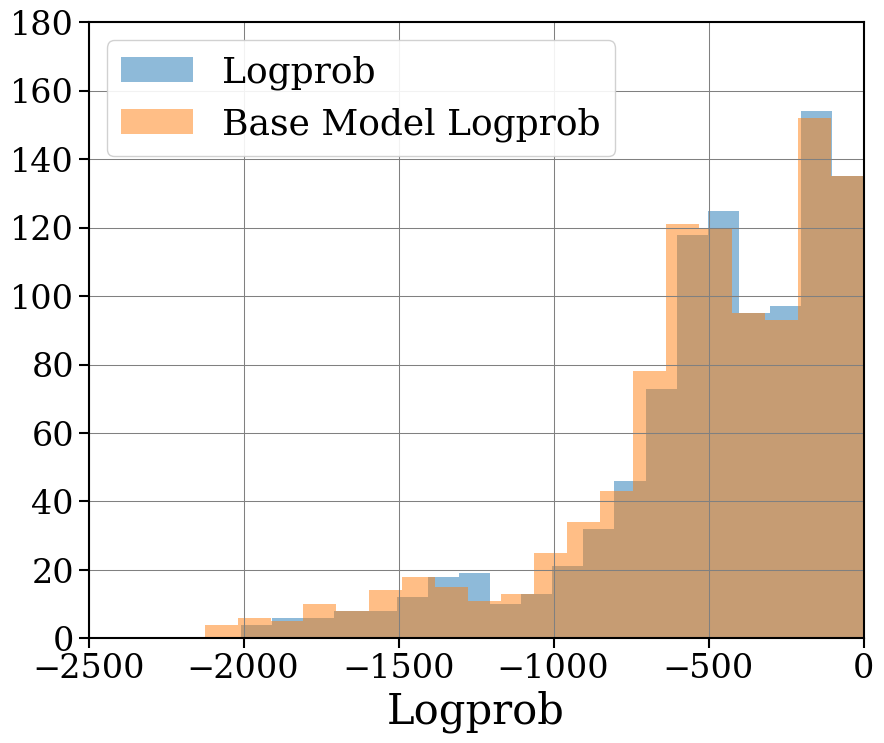

In [62]:
fig, ax  = plt.subplots()
bins = 20
alpha = 0.5
ax.hist(temp['logprob'], bins=bins, alpha=alpha, label='Logprob')
ax.hist(temp['base_model_logprob'], bins=bins, alpha=alpha, label='Base Model Logprob')

ax.legend()
ax.set_xlabel('Logprob')

# fig.suptitle(f"Logprob Comparison ({alias})")

plt.show()

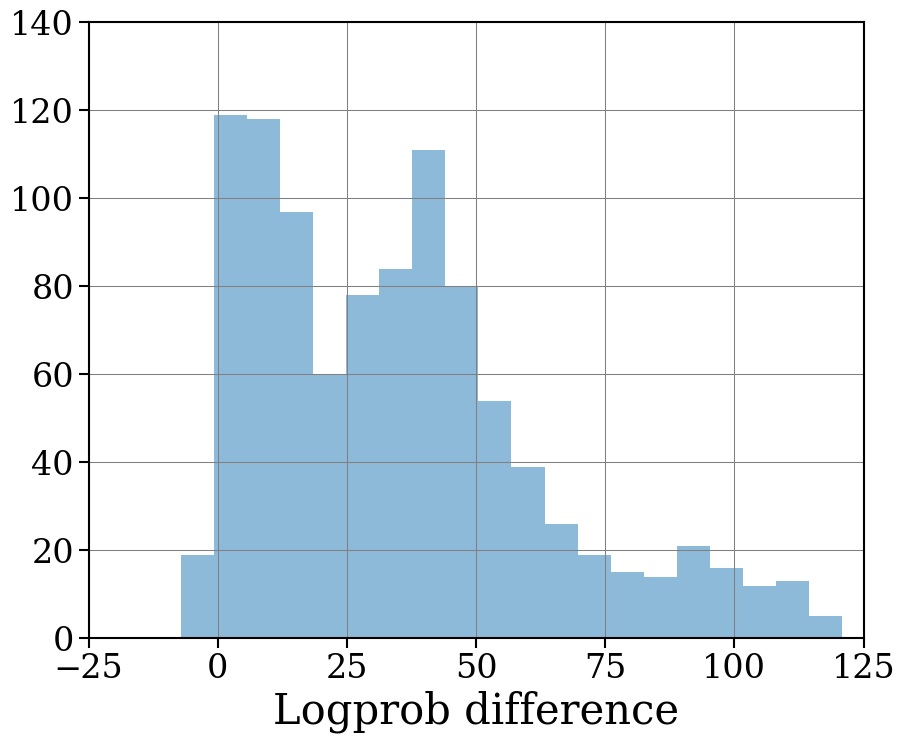

In [63]:
fig, ax  = plt.subplots()
bins = 20
alpha = 0.5
ax.hist(temp['logprob'] - temp['base_model_logprob'], bins=bins, alpha=alpha, label='Logprob')
# ax.hist(temp['base_model_logprob'], bins=bins, alpha=alpha, label='Base Model Logprob')

# ax.legend()
ax.set_xlabel('Logprob difference')

# fig.suptitle(f"Logprob Comparison ({alias})")

plt.show()